In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import medmnist
from medmnist import INFO, Evaluator
data_flag = 'bloodmnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 10
BATCH_SIZE = 16
lr = 0.005

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [3]:
import torch.utils.data as data
import torchvision.transforms as transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

val_dataset = DataClass(split='val', download=download)

In [4]:
neu_train_dataset = DataClass(split = 'train', transform=data_transform)
neu_val_dataset = DataClass(split = 'val', transform=data_transform)
neu_test_dataset = DataClass(split = 'test', transform=data_transform)

In [5]:
import numpy as np
idx = (train_dataset.labels==6) 
neu_train_dataset.labels = train_dataset.labels[idx]
neu_train_dataset.imgs = train_dataset.imgs[idx.squeeze()]

idx = (val_dataset.labels==6) 
neu_val_dataset.labels = val_dataset.labels[idx]
neu_val_dataset.imgs = val_dataset.imgs[idx.squeeze()]

idx = (test_dataset.labels==6) 
neu_test_dataset.labels = test_dataset.labels[idx]
neu_test_dataset.imgs = test_dataset.imgs[idx.squeeze()]

In [6]:
train_loader = data.DataLoader(dataset=neu_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=neu_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=neu_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# VAE-GAN

In [7]:
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [8]:
class Config:
    g_lr = 2e-4
    d_lr = 2e-5
    nz = 32
    image_size = 28
    nc = 3
    ngf = 28
    ndf = 28 
    beta1 = 0.5
    batch_size = 32
    max_epoch = 100
    workers = 2
    gpu = True

opt=Config()


In [9]:
netg = nn.Sequential(
    nn.ConvTranspose2d(opt.nz,opt.ngf*8,4,2,0,bias=False),
    nn.BatchNorm2d(opt.ngf*8),
    nn.ReLU(True),

    nn.ConvTranspose2d(opt.ngf*8,opt.ngf*4,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ngf*4),
    nn.ReLU(True),

    nn.ConvTranspose2d(opt.ngf*4,opt.ngf*2,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ngf*2),
    nn.ReLU(True),

    nn.ConvTranspose2d(opt.ngf*2,opt.ngf*1,2,1,1,bias=False),
    nn.BatchNorm2d(opt.ngf*1),
    nn.ReLU(True),

    # no batchnormalization in the last layer of the generator
    nn.ConvTranspose2d(opt.ngf,opt.nc,2,2,1,bias=False),
    nn.Tanh() # tanh instead of sigmoid
)

In [11]:
from torchsummary import summary

summary(netg.cuda(),(32,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 224, 4, 4]         114,688
       BatchNorm2d-2            [-1, 224, 4, 4]             448
              ReLU-3            [-1, 224, 4, 4]               0
   ConvTranspose2d-4            [-1, 112, 8, 8]         401,408
       BatchNorm2d-5            [-1, 112, 8, 8]             224
              ReLU-6            [-1, 112, 8, 8]               0
   ConvTranspose2d-7           [-1, 56, 16, 16]         100,352
       BatchNorm2d-8           [-1, 56, 16, 16]             112
              ReLU-9           [-1, 56, 16, 16]               0
  ConvTranspose2d-10           [-1, 28, 15, 15]           6,272
      BatchNorm2d-11           [-1, 28, 15, 15]              56
             ReLU-12           [-1, 28, 15, 15]               0
  ConvTranspose2d-13            [-1, 3, 28, 28]             336
             Tanh-14            [-1, 3,

In [12]:
netd = nn.Sequential(
    # no batchnormalization in the first layer of the discriminator
    nn.Conv2d(opt.nc,opt.ndf,3,1,1,bias=False),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(opt.ndf,opt.ndf*2,3,2,1,bias=False),
    nn.BatchNorm2d(opt.ndf*2),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(opt.ndf*2,opt.ndf*4,3,2,1,bias=False),
    nn.BatchNorm2d(opt.ndf*4),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(opt.ndf*4,opt.ndf*8,3,2,1,bias=False),
    nn.BatchNorm2d(opt.ndf*8),
    nn.LeakyReLU(0.2,inplace=True),
  
    nn.Conv2d(opt.ndf*8,1,3,2,0,bias=False),
    nn.Sigmoid()
    
)

In [13]:
from torchsummary import summary

summary(netd.cuda(),(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 28, 28]             756
         LeakyReLU-2           [-1, 28, 28, 28]               0
            Conv2d-3           [-1, 56, 14, 14]          14,112
       BatchNorm2d-4           [-1, 56, 14, 14]             112
         LeakyReLU-5           [-1, 56, 14, 14]               0
            Conv2d-6            [-1, 112, 7, 7]          56,448
       BatchNorm2d-7            [-1, 112, 7, 7]             224
         LeakyReLU-8            [-1, 112, 7, 7]               0
            Conv2d-9            [-1, 224, 4, 4]         225,792
      BatchNorm2d-10            [-1, 224, 4, 4]             448
        LeakyReLU-11            [-1, 224, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           2,016
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 299,908
Trainable params:

In [14]:
optimizerD = Adam(netd.parameters(),lr=opt.d_lr,betas=(opt.beta1,0.999))
optimizerG = Adam(netg.parameters(),lr=opt.g_lr,betas=(opt.beta1,0.999))

criterion = nn.BCELoss()

fix_noise = torch.FloatTensor(opt.batch_size,opt.nz,1,1).normal_(0,1)
if opt.gpu:
    fix_noise = fix_noise.cuda()
    netd.cuda()
    netg.cuda()
    criterion.cuda()

Epoch: [ 0] [   0/ 146] time: 0.4898, d_loss: 1.28221774, g_loss: 0.65162402
Epoch: [ 0] [   1/ 146] time: 0.5040, d_loss: 1.36769569, g_loss: 0.60706306
Epoch: [ 0] [   2/ 146] time: 0.5181, d_loss: 1.61823881, g_loss: 0.50735068
Epoch: [ 0] [   3/ 146] time: 0.5325, d_loss: 1.72378886, g_loss: 0.34978154
Epoch: [ 0] [   4/ 146] time: 0.5467, d_loss: 1.78960967, g_loss: 0.30761629
Epoch: [ 0] [   5/ 146] time: 0.5608, d_loss: 1.88622546, g_loss: 0.23108533
Epoch: [ 0] [   6/ 146] time: 0.5751, d_loss: 1.93339205, g_loss: 0.21750829
Epoch: [ 0] [   7/ 146] time: 0.5894, d_loss: 1.95536554, g_loss: 0.21669233
Epoch: [ 0] [   8/ 146] time: 0.6036, d_loss: 2.02010369, g_loss: 0.21334702
Epoch: [ 0] [   9/ 146] time: 0.6179, d_loss: 2.20724249, g_loss: 0.21507852
Epoch: [ 0] [  10/ 146] time: 0.6322, d_loss: 2.05017614, g_loss: 0.19310004
Epoch: [ 0] [  11/ 146] time: 0.6465, d_loss: 2.18212485, g_loss: 0.18236962
Epoch: [ 0] [  12/ 146] time: 0.6609, d_loss: 2.04994202, g_loss: 0.19693550

Epoch: [ 0] [ 109/ 146] time: 2.1545, d_loss: 1.36626446, g_loss: 0.46575719
Epoch: [ 0] [ 110/ 146] time: 2.1696, d_loss: 1.33639121, g_loss: 0.38601691
Epoch: [ 0] [ 111/ 146] time: 2.1834, d_loss: 1.38425088, g_loss: 0.44411567
Epoch: [ 0] [ 112/ 146] time: 2.1976, d_loss: 1.41780472, g_loss: 0.42274269
Epoch: [ 0] [ 113/ 146] time: 2.2115, d_loss: 1.39961195, g_loss: 0.39651689
Epoch: [ 0] [ 114/ 146] time: 2.2259, d_loss: 1.41700864, g_loss: 0.41949135
Epoch: [ 0] [ 115/ 146] time: 2.2399, d_loss: 1.36812520, g_loss: 0.44443926
Epoch: [ 0] [ 116/ 146] time: 2.2541, d_loss: 1.43529058, g_loss: 0.42803222
Epoch: [ 0] [ 117/ 146] time: 2.2680, d_loss: 1.46665895, g_loss: 0.41222239
Epoch: [ 0] [ 118/ 146] time: 2.2822, d_loss: 1.47479308, g_loss: 0.41258121
Epoch: [ 0] [ 119/ 146] time: 2.2968, d_loss: 1.42373407, g_loss: 0.41200143
Epoch: [ 0] [ 120/ 146] time: 2.3121, d_loss: 1.47666800, g_loss: 0.41700283
Epoch: [ 0] [ 121/ 146] time: 2.3272, d_loss: 1.48669839, g_loss: 0.43135631

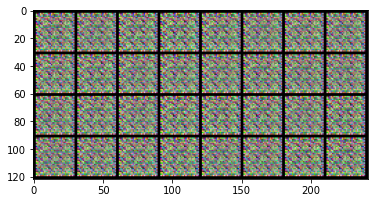

Epoch: [ 1] [   0/ 146] time: 2.9507, d_loss: 1.32720435, g_loss: 0.48383719
Epoch: [ 1] [   1/ 146] time: 2.9667, d_loss: 1.31503153, g_loss: 0.46609712
Epoch: [ 1] [   2/ 146] time: 2.9813, d_loss: 1.23919129, g_loss: 0.47476470
Epoch: [ 1] [   3/ 146] time: 2.9962, d_loss: 1.32702696, g_loss: 0.45250243
Epoch: [ 1] [   4/ 146] time: 3.0102, d_loss: 1.32524335, g_loss: 0.47346514
Epoch: [ 1] [   5/ 146] time: 3.0240, d_loss: 1.35624790, g_loss: 0.47739381
Epoch: [ 1] [   6/ 146] time: 3.0377, d_loss: 1.32608938, g_loss: 0.46618402
Epoch: [ 1] [   7/ 146] time: 3.0513, d_loss: 1.27786505, g_loss: 0.47934464
Epoch: [ 1] [   8/ 146] time: 3.0649, d_loss: 1.24548531, g_loss: 0.50522518
Epoch: [ 1] [   9/ 146] time: 3.0786, d_loss: 1.17952478, g_loss: 0.53833544
Epoch: [ 1] [  10/ 146] time: 3.0921, d_loss: 1.13173580, g_loss: 0.57905090
Epoch: [ 1] [  11/ 146] time: 3.1057, d_loss: 1.02361453, g_loss: 0.63697815
Epoch: [ 1] [  12/ 146] time: 3.1193, d_loss: 0.96052295, g_loss: 0.69726151

Epoch: [ 1] [ 109/ 146] time: 4.6476, d_loss: 0.83161104, g_loss: 0.89976031
Epoch: [ 1] [ 110/ 146] time: 4.6630, d_loss: 0.88787425, g_loss: 0.86439562
Epoch: [ 1] [ 111/ 146] time: 4.6782, d_loss: 0.95522481, g_loss: 0.71143055
Epoch: [ 1] [ 112/ 146] time: 4.6936, d_loss: 0.97747707, g_loss: 0.72978795
Epoch: [ 1] [ 113/ 146] time: 4.7082, d_loss: 0.92900509, g_loss: 0.81057328
Epoch: [ 1] [ 114/ 146] time: 4.7225, d_loss: 0.92209220, g_loss: 0.81592298
Epoch: [ 1] [ 115/ 146] time: 4.7366, d_loss: 0.85809684, g_loss: 0.85243797
Epoch: [ 1] [ 116/ 146] time: 4.7508, d_loss: 0.84778166, g_loss: 0.84435582
Epoch: [ 1] [ 117/ 146] time: 4.7647, d_loss: 0.83433026, g_loss: 0.87114775
Epoch: [ 1] [ 118/ 146] time: 4.7787, d_loss: 0.81535739, g_loss: 0.85866106
Epoch: [ 1] [ 119/ 146] time: 4.7926, d_loss: 0.82929599, g_loss: 0.85904372
Epoch: [ 1] [ 120/ 146] time: 4.8064, d_loss: 0.85331899, g_loss: 0.83142519
Epoch: [ 1] [ 121/ 146] time: 4.8202, d_loss: 0.87038374, g_loss: 0.81336343

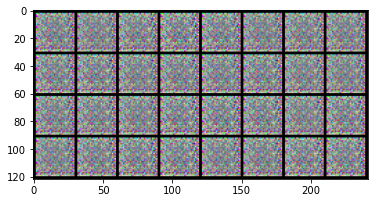

Epoch: [ 2] [   0/ 146] time: 5.3495, d_loss: 0.72933167, g_loss: 0.96811050
Epoch: [ 2] [   1/ 146] time: 5.3642, d_loss: 0.74661988, g_loss: 0.90008688
Epoch: [ 2] [   2/ 146] time: 5.3783, d_loss: 0.71077216, g_loss: 0.96684164
Epoch: [ 2] [   3/ 146] time: 5.3923, d_loss: 0.67899621, g_loss: 1.05952168
Epoch: [ 2] [   4/ 146] time: 5.4077, d_loss: 0.74518371, g_loss: 0.97600877
Epoch: [ 2] [   5/ 146] time: 5.4234, d_loss: 0.73951840, g_loss: 0.96878624
Epoch: [ 2] [   6/ 146] time: 5.4392, d_loss: 0.77554071, g_loss: 0.96584958
Epoch: [ 2] [   7/ 146] time: 5.4544, d_loss: 0.73180771, g_loss: 0.95893639
Epoch: [ 2] [   8/ 146] time: 5.4687, d_loss: 0.69928491, g_loss: 0.93124056
Epoch: [ 2] [   9/ 146] time: 5.4829, d_loss: 0.78793108, g_loss: 0.99912560
Epoch: [ 2] [  10/ 146] time: 5.4971, d_loss: 0.71266973, g_loss: 0.97921628
Epoch: [ 2] [  11/ 146] time: 5.5112, d_loss: 0.71586645, g_loss: 0.98652446
Epoch: [ 2] [  12/ 146] time: 5.5253, d_loss: 0.74971789, g_loss: 0.91069001

Epoch: [ 2] [ 117/ 146] time: 7.0373, d_loss: 0.48646885, g_loss: 1.39235854
Epoch: [ 2] [ 118/ 146] time: 7.0522, d_loss: 0.45503843, g_loss: 1.27166831
Epoch: [ 2] [ 119/ 146] time: 7.0661, d_loss: 0.47121450, g_loss: 1.27772999
Epoch: [ 2] [ 120/ 146] time: 7.0797, d_loss: 0.46875533, g_loss: 1.29610944
Epoch: [ 2] [ 121/ 146] time: 7.0933, d_loss: 0.44385749, g_loss: 1.38117492
Epoch: [ 2] [ 122/ 146] time: 7.1069, d_loss: 0.44145304, g_loss: 1.32211065
Epoch: [ 2] [ 123/ 146] time: 7.1206, d_loss: 0.43549848, g_loss: 1.29074848
Epoch: [ 2] [ 124/ 146] time: 7.1343, d_loss: 0.42906255, g_loss: 1.35423851
Epoch: [ 2] [ 125/ 146] time: 7.1479, d_loss: 0.43489578, g_loss: 1.36760902
Epoch: [ 2] [ 126/ 146] time: 7.1614, d_loss: 0.44345582, g_loss: 1.37675071
Epoch: [ 2] [ 127/ 146] time: 7.1750, d_loss: 0.50121468, g_loss: 1.32953620
Epoch: [ 2] [ 128/ 146] time: 7.1886, d_loss: 0.45803887, g_loss: 1.30402255
Epoch: [ 2] [ 129/ 146] time: 7.2025, d_loss: 0.44658792, g_loss: 1.32784975

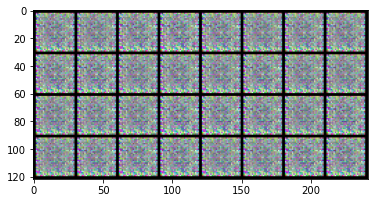

Epoch: [ 3] [   0/ 146] time: 7.6185, d_loss: 0.36418027, g_loss: 1.47022128
Epoch: [ 3] [   1/ 146] time: 7.6334, d_loss: 0.40394208, g_loss: 1.41125298
Epoch: [ 3] [   2/ 146] time: 7.6472, d_loss: 0.41614148, g_loss: 1.35801566
Epoch: [ 3] [   3/ 146] time: 7.6613, d_loss: 0.41767725, g_loss: 1.37039936
Epoch: [ 3] [   4/ 146] time: 7.6753, d_loss: 0.45568961, g_loss: 1.31639624
Epoch: [ 3] [   5/ 146] time: 7.6892, d_loss: 0.45772997, g_loss: 1.29692054
Epoch: [ 3] [   6/ 146] time: 7.7037, d_loss: 0.48691702, g_loss: 1.21406651
Epoch: [ 3] [   7/ 146] time: 7.7178, d_loss: 0.51833308, g_loss: 1.33621860
Epoch: [ 3] [   8/ 146] time: 7.7319, d_loss: 0.48197672, g_loss: 1.26659703
Epoch: [ 3] [   9/ 146] time: 7.7459, d_loss: 0.46782139, g_loss: 1.28948879
Epoch: [ 3] [  10/ 146] time: 7.7600, d_loss: 0.45816806, g_loss: 1.31672275
Epoch: [ 3] [  11/ 146] time: 7.7739, d_loss: 0.44226885, g_loss: 1.35365987
Epoch: [ 3] [  12/ 146] time: 7.7878, d_loss: 0.43185031, g_loss: 1.38193560

Epoch: [ 3] [ 114/ 146] time: 9.2914, d_loss: 0.36056396, g_loss: 1.59135580
Epoch: [ 3] [ 115/ 146] time: 9.3064, d_loss: 0.35409948, g_loss: 1.68658161
Epoch: [ 3] [ 116/ 146] time: 9.3231, d_loss: 0.30117437, g_loss: 1.80358827
Epoch: [ 3] [ 117/ 146] time: 9.3383, d_loss: 0.25342199, g_loss: 1.95130980
Epoch: [ 3] [ 118/ 146] time: 9.3530, d_loss: 0.33840254, g_loss: 1.66284752
Epoch: [ 3] [ 119/ 146] time: 9.3679, d_loss: 0.36369240, g_loss: 1.60571241
Epoch: [ 3] [ 120/ 146] time: 9.3832, d_loss: 0.42257905, g_loss: 1.66634607
Epoch: [ 3] [ 121/ 146] time: 9.3981, d_loss: 0.37466776, g_loss: 1.69630861
Epoch: [ 3] [ 122/ 146] time: 9.4129, d_loss: 0.33130997, g_loss: 1.81308436
Epoch: [ 3] [ 123/ 146] time: 9.4274, d_loss: 0.29624188, g_loss: 1.86707342
Epoch: [ 3] [ 124/ 146] time: 9.4423, d_loss: 0.25810039, g_loss: 1.94938517
Epoch: [ 3] [ 125/ 146] time: 9.4572, d_loss: 0.28475690, g_loss: 1.98662388
Epoch: [ 3] [ 126/ 146] time: 9.4716, d_loss: 0.27882031, g_loss: 1.80253863

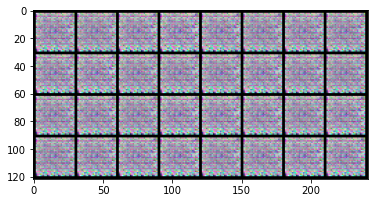

Epoch: [ 4] [   0/ 146] time: 9.9292, d_loss: 0.24862988, g_loss: 2.03242636
Epoch: [ 4] [   1/ 146] time: 9.9451, d_loss: 0.25745696, g_loss: 2.00020313
Epoch: [ 4] [   2/ 146] time: 9.9595, d_loss: 0.26007390, g_loss: 1.92412901
Epoch: [ 4] [   3/ 146] time: 9.9738, d_loss: 0.32348269, g_loss: 1.76801801
Epoch: [ 4] [   4/ 146] time: 9.9880, d_loss: 0.27387875, g_loss: 1.86786890
Epoch: [ 4] [   5/ 146] time: 10.0022, d_loss: 0.25219917, g_loss: 1.91276145
Epoch: [ 4] [   6/ 146] time: 10.0179, d_loss: 0.26754764, g_loss: 1.92136395
Epoch: [ 4] [   7/ 146] time: 10.0319, d_loss: 0.23742232, g_loss: 1.96203685
Epoch: [ 4] [   8/ 146] time: 10.0459, d_loss: 0.30275649, g_loss: 1.93969405
Epoch: [ 4] [   9/ 146] time: 10.0599, d_loss: 0.23021570, g_loss: 2.03870869
Epoch: [ 4] [  10/ 146] time: 10.0739, d_loss: 0.27968621, g_loss: 2.04497814
Epoch: [ 4] [  11/ 146] time: 10.0879, d_loss: 0.25710714, g_loss: 1.93660259
Epoch: [ 4] [  12/ 146] time: 10.1021, d_loss: 0.22633898, g_loss: 2.

Epoch: [ 4] [ 116/ 146] time: 11.6083, d_loss: 0.48886475, g_loss: 1.53267825
Epoch: [ 4] [ 117/ 146] time: 11.6241, d_loss: 0.68051702, g_loss: 1.44384027
Epoch: [ 4] [ 118/ 146] time: 11.6395, d_loss: 1.19944489, g_loss: 1.05718660
Epoch: [ 4] [ 119/ 146] time: 11.6544, d_loss: 1.46416438, g_loss: 1.02689862
Epoch: [ 4] [ 120/ 146] time: 11.6692, d_loss: 1.22540784, g_loss: 1.16248429
Epoch: [ 4] [ 121/ 146] time: 11.6832, d_loss: 1.25406265, g_loss: 1.23373151
Epoch: [ 4] [ 122/ 146] time: 11.6983, d_loss: 0.97176707, g_loss: 0.97468901
Epoch: [ 4] [ 123/ 146] time: 11.7125, d_loss: 1.72234058, g_loss: 0.57966876
Epoch: [ 4] [ 124/ 146] time: 11.7267, d_loss: 1.66225863, g_loss: 0.81708390
Epoch: [ 4] [ 125/ 146] time: 11.7410, d_loss: 1.46515656, g_loss: 0.95502865
Epoch: [ 4] [ 126/ 146] time: 11.7553, d_loss: 1.37585664, g_loss: 0.95370674
Epoch: [ 4] [ 127/ 146] time: 11.7692, d_loss: 0.97375476, g_loss: 1.00688744
Epoch: [ 4] [ 128/ 146] time: 11.7829, d_loss: 0.79148006, g_los

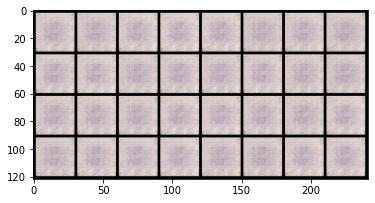

Epoch: [ 5] [   0/ 146] time: 12.2249, d_loss: 1.66323543, g_loss: 0.56444663
Epoch: [ 5] [   1/ 146] time: 12.2408, d_loss: 1.67748940, g_loss: 0.77479571
Epoch: [ 5] [   2/ 146] time: 12.2559, d_loss: 2.00176668, g_loss: 0.71859777
Epoch: [ 5] [   3/ 146] time: 12.2709, d_loss: 2.02220178, g_loss: 0.71169734
Epoch: [ 5] [   4/ 146] time: 12.2856, d_loss: 1.75853801, g_loss: 0.70299196
Epoch: [ 5] [   5/ 146] time: 12.2998, d_loss: 1.83617067, g_loss: 0.69675839
Epoch: [ 5] [   6/ 146] time: 12.3135, d_loss: 1.92563665, g_loss: 0.64362174
Epoch: [ 5] [   7/ 146] time: 12.3273, d_loss: 2.28993630, g_loss: 0.54748154
Epoch: [ 5] [   8/ 146] time: 12.3411, d_loss: 1.93441737, g_loss: 0.54736984
Epoch: [ 5] [   9/ 146] time: 12.3548, d_loss: 1.88200736, g_loss: 0.66195077
Epoch: [ 5] [  10/ 146] time: 12.3685, d_loss: 1.83131886, g_loss: 0.83558273
Epoch: [ 5] [  11/ 146] time: 12.3824, d_loss: 1.65493393, g_loss: 0.75336891
Epoch: [ 5] [  12/ 146] time: 12.3962, d_loss: 1.95332146, g_los

Epoch: [ 5] [ 116/ 146] time: 13.9089, d_loss: 1.53185129, g_loss: 0.73636943
Epoch: [ 5] [ 117/ 146] time: 13.9242, d_loss: 1.45398390, g_loss: 0.75490320
Epoch: [ 5] [ 118/ 146] time: 13.9395, d_loss: 1.57422376, g_loss: 0.76857567
Epoch: [ 5] [ 119/ 146] time: 13.9551, d_loss: 1.49489176, g_loss: 0.74080956
Epoch: [ 5] [ 120/ 146] time: 13.9705, d_loss: 1.46728766, g_loss: 0.74951506
Epoch: [ 5] [ 121/ 146] time: 13.9860, d_loss: 1.56180334, g_loss: 0.75774527
Epoch: [ 5] [ 122/ 146] time: 14.0010, d_loss: 1.42373538, g_loss: 0.74750078
Epoch: [ 5] [ 123/ 146] time: 14.0160, d_loss: 1.43441904, g_loss: 0.74927819
Epoch: [ 5] [ 124/ 146] time: 14.0304, d_loss: 1.66311669, g_loss: 0.73598498
Epoch: [ 5] [ 125/ 146] time: 14.0444, d_loss: 1.53292274, g_loss: 0.74172735
Epoch: [ 5] [ 126/ 146] time: 14.0584, d_loss: 1.46291149, g_loss: 0.73233265
Epoch: [ 5] [ 127/ 146] time: 14.0723, d_loss: 1.56942749, g_loss: 0.72163188
Epoch: [ 5] [ 128/ 146] time: 14.0861, d_loss: 1.58847189, g_los

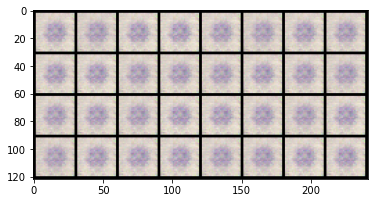

Epoch: [ 6] [   0/ 146] time: 14.5292, d_loss: 1.50016284, g_loss: 0.70429367
Epoch: [ 6] [   1/ 146] time: 14.5444, d_loss: 1.46949160, g_loss: 0.71561432
Epoch: [ 6] [   2/ 146] time: 14.5586, d_loss: 1.52327466, g_loss: 0.71997672
Epoch: [ 6] [   3/ 146] time: 14.5727, d_loss: 1.55039513, g_loss: 0.72116363
Epoch: [ 6] [   4/ 146] time: 14.5864, d_loss: 1.46878862, g_loss: 0.72129244
Epoch: [ 6] [   5/ 146] time: 14.6001, d_loss: 1.51370203, g_loss: 0.74172938
Epoch: [ 6] [   6/ 146] time: 14.6141, d_loss: 1.54227304, g_loss: 0.75225246
Epoch: [ 6] [   7/ 146] time: 14.6277, d_loss: 1.44839883, g_loss: 0.75046456
Epoch: [ 6] [   8/ 146] time: 14.6415, d_loss: 1.51646376, g_loss: 0.74860477
Epoch: [ 6] [   9/ 146] time: 14.6552, d_loss: 1.54896879, g_loss: 0.74340469
Epoch: [ 6] [  10/ 146] time: 14.6690, d_loss: 1.69115615, g_loss: 0.71018696
Epoch: [ 6] [  11/ 146] time: 14.6827, d_loss: 1.70216560, g_loss: 0.71479940
Epoch: [ 6] [  12/ 146] time: 14.6964, d_loss: 1.72794485, g_los

Epoch: [ 6] [ 116/ 146] time: 16.2115, d_loss: 1.51358485, g_loss: 0.71147096
Epoch: [ 6] [ 117/ 146] time: 16.2289, d_loss: 1.50632572, g_loss: 0.70937479
Epoch: [ 6] [ 118/ 146] time: 16.2442, d_loss: 1.43069136, g_loss: 0.71023703
Epoch: [ 6] [ 119/ 146] time: 16.2597, d_loss: 1.48101628, g_loss: 0.69668382
Epoch: [ 6] [ 120/ 146] time: 16.2744, d_loss: 1.43943655, g_loss: 0.72424763
Epoch: [ 6] [ 121/ 146] time: 16.2894, d_loss: 1.47314644, g_loss: 0.71185637
Epoch: [ 6] [ 122/ 146] time: 16.3044, d_loss: 1.46962190, g_loss: 0.73921263
Epoch: [ 6] [ 123/ 146] time: 16.3196, d_loss: 1.48747027, g_loss: 0.73312044
Epoch: [ 6] [ 124/ 146] time: 16.3346, d_loss: 1.46499217, g_loss: 0.72186065
Epoch: [ 6] [ 125/ 146] time: 16.3495, d_loss: 1.50898218, g_loss: 0.71293509
Epoch: [ 6] [ 126/ 146] time: 16.3644, d_loss: 1.45854986, g_loss: 0.70638931
Epoch: [ 6] [ 127/ 146] time: 16.3796, d_loss: 1.51481390, g_loss: 0.70648926
Epoch: [ 6] [ 128/ 146] time: 16.3946, d_loss: 1.43682551, g_los

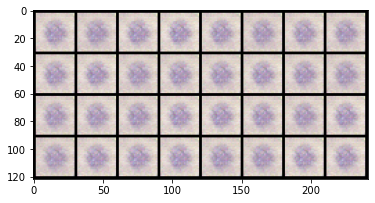

Epoch: [ 7] [   0/ 146] time: 16.8478, d_loss: 1.46266770, g_loss: 0.73541468
Epoch: [ 7] [   1/ 146] time: 16.8632, d_loss: 1.44082868, g_loss: 0.73113286
Epoch: [ 7] [   2/ 146] time: 16.8785, d_loss: 1.49442792, g_loss: 0.73884857
Epoch: [ 7] [   3/ 146] time: 16.8939, d_loss: 1.45228815, g_loss: 0.74751663
Epoch: [ 7] [   4/ 146] time: 16.9100, d_loss: 1.43702459, g_loss: 0.73982441
Epoch: [ 7] [   5/ 146] time: 16.9252, d_loss: 1.49217033, g_loss: 0.75565588
Epoch: [ 7] [   6/ 146] time: 16.9416, d_loss: 1.48157430, g_loss: 0.73766094
Epoch: [ 7] [   7/ 146] time: 16.9578, d_loss: 1.43569398, g_loss: 0.74476039
Epoch: [ 7] [   8/ 146] time: 16.9730, d_loss: 1.41940975, g_loss: 0.76134491
Epoch: [ 7] [   9/ 146] time: 16.9888, d_loss: 1.47654378, g_loss: 0.75310421
Epoch: [ 7] [  10/ 146] time: 17.0046, d_loss: 1.48895121, g_loss: 0.75540638
Epoch: [ 7] [  11/ 146] time: 17.0198, d_loss: 1.46147275, g_loss: 0.76033151
Epoch: [ 7] [  12/ 146] time: 17.0356, d_loss: 1.46313024, g_los

Epoch: [ 7] [ 115/ 146] time: 18.5304, d_loss: 1.46649337, g_loss: 0.71263903
Epoch: [ 7] [ 116/ 146] time: 18.5454, d_loss: 1.48257697, g_loss: 0.71846497
Epoch: [ 7] [ 117/ 146] time: 18.5599, d_loss: 1.46897006, g_loss: 0.72934121
Epoch: [ 7] [ 118/ 146] time: 18.5738, d_loss: 1.45069253, g_loss: 0.72921860
Epoch: [ 7] [ 119/ 146] time: 18.5876, d_loss: 1.50702167, g_loss: 0.73129582
Epoch: [ 7] [ 120/ 146] time: 18.6015, d_loss: 1.48622417, g_loss: 0.72744346
Epoch: [ 7] [ 121/ 146] time: 18.6154, d_loss: 1.47019970, g_loss: 0.73875350
Epoch: [ 7] [ 122/ 146] time: 18.6294, d_loss: 1.53210521, g_loss: 0.73364615
Epoch: [ 7] [ 123/ 146] time: 18.6433, d_loss: 1.46432710, g_loss: 0.73800814
Epoch: [ 7] [ 124/ 146] time: 18.6572, d_loss: 1.61841178, g_loss: 0.72803038
Epoch: [ 7] [ 125/ 146] time: 18.6710, d_loss: 1.47775888, g_loss: 0.73406959
Epoch: [ 7] [ 126/ 146] time: 18.6848, d_loss: 1.49794579, g_loss: 0.74699134
Epoch: [ 7] [ 127/ 146] time: 18.6986, d_loss: 1.54865193, g_los

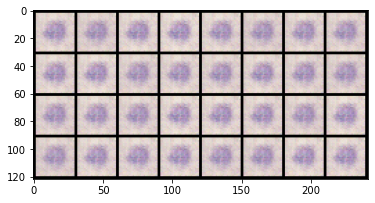

Epoch: [ 8] [   0/ 146] time: 19.1929, d_loss: 1.38404346, g_loss: 0.78901857
Epoch: [ 8] [   1/ 146] time: 19.2088, d_loss: 1.37417579, g_loss: 0.78147405
Epoch: [ 8] [   2/ 146] time: 19.2243, d_loss: 1.36901283, g_loss: 0.77427924
Epoch: [ 8] [   3/ 146] time: 19.2408, d_loss: 1.50983620, g_loss: 0.74846947
Epoch: [ 8] [   4/ 146] time: 19.2560, d_loss: 1.41517186, g_loss: 0.74918878
Epoch: [ 8] [   5/ 146] time: 19.2709, d_loss: 1.44102275, g_loss: 0.73944986
Epoch: [ 8] [   6/ 146] time: 19.2861, d_loss: 1.33189869, g_loss: 0.75711942
Epoch: [ 8] [   7/ 146] time: 19.3011, d_loss: 1.40126729, g_loss: 0.76974732
Epoch: [ 8] [   8/ 146] time: 19.3161, d_loss: 1.39521265, g_loss: 0.76698542
Epoch: [ 8] [   9/ 146] time: 19.3310, d_loss: 1.36941659, g_loss: 0.78822106
Epoch: [ 8] [  10/ 146] time: 19.3458, d_loss: 1.40680206, g_loss: 0.77443522
Epoch: [ 8] [  11/ 146] time: 19.3606, d_loss: 1.37737870, g_loss: 0.76983571
Epoch: [ 8] [  12/ 146] time: 19.3759, d_loss: 1.40746951, g_los

Epoch: [ 8] [ 110/ 146] time: 20.9236, d_loss: 1.44496107, g_loss: 0.73864090
Epoch: [ 8] [ 111/ 146] time: 20.9387, d_loss: 1.40965414, g_loss: 0.74963742
Epoch: [ 8] [ 112/ 146] time: 20.9537, d_loss: 1.38588905, g_loss: 0.75689304
Epoch: [ 8] [ 113/ 146] time: 20.9690, d_loss: 1.47788572, g_loss: 0.76309478
Epoch: [ 8] [ 114/ 146] time: 20.9840, d_loss: 1.43171906, g_loss: 0.73549062
Epoch: [ 8] [ 115/ 146] time: 20.9989, d_loss: 1.38579702, g_loss: 0.75120366
Epoch: [ 8] [ 116/ 146] time: 21.0137, d_loss: 1.45295346, g_loss: 0.72522259
Epoch: [ 8] [ 117/ 146] time: 21.0285, d_loss: 1.40087903, g_loss: 0.71944571
Epoch: [ 8] [ 118/ 146] time: 21.0431, d_loss: 1.46277428, g_loss: 0.73181736
Epoch: [ 8] [ 119/ 146] time: 21.0580, d_loss: 1.39141250, g_loss: 0.74272549
Epoch: [ 8] [ 120/ 146] time: 21.0730, d_loss: 1.41508269, g_loss: 0.73361945
Epoch: [ 8] [ 121/ 146] time: 21.0878, d_loss: 1.44827318, g_loss: 0.73215985
Epoch: [ 8] [ 122/ 146] time: 21.1030, d_loss: 1.43990266, g_los

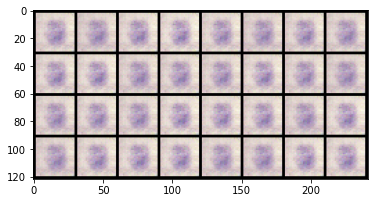

Epoch: [ 9] [   0/ 146] time: 21.6416, d_loss: 1.62854362, g_loss: 0.66617250
Epoch: [ 9] [   1/ 146] time: 21.6564, d_loss: 1.63676560, g_loss: 0.64714938
Epoch: [ 9] [   2/ 146] time: 21.6712, d_loss: 1.57818985, g_loss: 0.65496826
Epoch: [ 9] [   3/ 146] time: 21.6862, d_loss: 1.63188291, g_loss: 0.65373814
Epoch: [ 9] [   4/ 146] time: 21.7012, d_loss: 1.67233133, g_loss: 0.66200691
Epoch: [ 9] [   5/ 146] time: 21.7163, d_loss: 1.56016278, g_loss: 0.68975902
Epoch: [ 9] [   6/ 146] time: 21.7311, d_loss: 1.47850347, g_loss: 0.69150800
Epoch: [ 9] [   7/ 146] time: 21.7461, d_loss: 1.51139021, g_loss: 0.69091952
Epoch: [ 9] [   8/ 146] time: 21.7608, d_loss: 1.48477745, g_loss: 0.70271027
Epoch: [ 9] [   9/ 146] time: 21.7758, d_loss: 1.48238277, g_loss: 0.71337032
Epoch: [ 9] [  10/ 146] time: 21.7912, d_loss: 1.45629692, g_loss: 0.72925472
Epoch: [ 9] [  11/ 146] time: 21.8069, d_loss: 1.53020072, g_loss: 0.74776924
Epoch: [ 9] [  12/ 146] time: 21.8219, d_loss: 1.38993597, g_los

Epoch: [ 9] [ 119/ 146] time: 23.3246, d_loss: 1.34427011, g_loss: 0.76640254
Epoch: [ 9] [ 120/ 146] time: 23.3395, d_loss: 1.35305572, g_loss: 0.77663410
Epoch: [ 9] [ 121/ 146] time: 23.3534, d_loss: 1.41028595, g_loss: 0.77244282
Epoch: [ 9] [ 122/ 146] time: 23.3670, d_loss: 1.42748702, g_loss: 0.76617628
Epoch: [ 9] [ 123/ 146] time: 23.3808, d_loss: 1.40167403, g_loss: 0.75373304
Epoch: [ 9] [ 124/ 146] time: 23.3944, d_loss: 1.45871043, g_loss: 0.73821265
Epoch: [ 9] [ 125/ 146] time: 23.4081, d_loss: 1.38803530, g_loss: 0.75033140
Epoch: [ 9] [ 126/ 146] time: 23.4217, d_loss: 1.34350514, g_loss: 0.77223194
Epoch: [ 9] [ 127/ 146] time: 23.4354, d_loss: 1.41183567, g_loss: 0.76798928
Epoch: [ 9] [ 128/ 146] time: 23.4491, d_loss: 1.38286984, g_loss: 0.76730859
Epoch: [ 9] [ 129/ 146] time: 23.4627, d_loss: 1.38222933, g_loss: 0.75015354
Epoch: [ 9] [ 130/ 146] time: 23.4763, d_loss: 1.37744367, g_loss: 0.76628447
Epoch: [ 9] [ 131/ 146] time: 23.4900, d_loss: 1.39455128, g_los

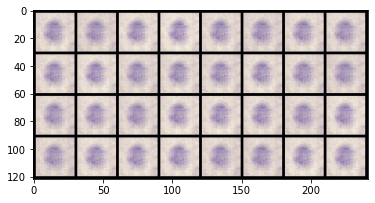

Epoch: [10] [   0/ 146] time: 23.8865, d_loss: 1.31694770, g_loss: 0.78869736
Epoch: [10] [   1/ 146] time: 23.9011, d_loss: 1.27796233, g_loss: 0.78134680
Epoch: [10] [   2/ 146] time: 23.9150, d_loss: 1.33456516, g_loss: 0.78963923
Epoch: [10] [   3/ 146] time: 23.9289, d_loss: 1.34230399, g_loss: 0.77134514
Epoch: [10] [   4/ 146] time: 23.9425, d_loss: 1.32783246, g_loss: 0.75735664
Epoch: [10] [   5/ 146] time: 23.9562, d_loss: 1.31544006, g_loss: 0.76410758
Epoch: [10] [   6/ 146] time: 23.9699, d_loss: 1.28433537, g_loss: 0.78938878
Epoch: [10] [   7/ 146] time: 23.9836, d_loss: 1.30259085, g_loss: 0.78835106
Epoch: [10] [   8/ 146] time: 23.9974, d_loss: 1.35628676, g_loss: 0.79969072
Epoch: [10] [   9/ 146] time: 24.0111, d_loss: 1.40793681, g_loss: 0.77814353
Epoch: [10] [  10/ 146] time: 24.0254, d_loss: 1.26425529, g_loss: 0.76496923
Epoch: [10] [  11/ 146] time: 24.0392, d_loss: 1.28550959, g_loss: 0.76799631
Epoch: [10] [  12/ 146] time: 24.0530, d_loss: 1.31642747, g_los

Epoch: [10] [ 120/ 146] time: 25.5667, d_loss: 1.13257504, g_loss: 0.91464090
Epoch: [10] [ 121/ 146] time: 25.5810, d_loss: 1.13334632, g_loss: 0.87036538
Epoch: [10] [ 122/ 146] time: 25.5951, d_loss: 1.18492436, g_loss: 0.85657930
Epoch: [10] [ 123/ 146] time: 25.6089, d_loss: 1.24976933, g_loss: 0.83869028
Epoch: [10] [ 124/ 146] time: 25.6227, d_loss: 1.19951701, g_loss: 0.86255997
Epoch: [10] [ 125/ 146] time: 25.6364, d_loss: 1.33424020, g_loss: 0.83556479
Epoch: [10] [ 126/ 146] time: 25.6502, d_loss: 1.21583629, g_loss: 0.83219421
Epoch: [10] [ 127/ 146] time: 25.6640, d_loss: 1.33235848, g_loss: 0.79949945
Epoch: [10] [ 128/ 146] time: 25.6780, d_loss: 1.33504403, g_loss: 0.77027690
Epoch: [10] [ 129/ 146] time: 25.6917, d_loss: 1.37344980, g_loss: 0.75905472
Epoch: [10] [ 130/ 146] time: 25.7054, d_loss: 1.33536673, g_loss: 0.79081750
Epoch: [10] [ 131/ 146] time: 25.7191, d_loss: 1.30449998, g_loss: 0.82181144
Epoch: [10] [ 132/ 146] time: 25.7329, d_loss: 1.31959605, g_los

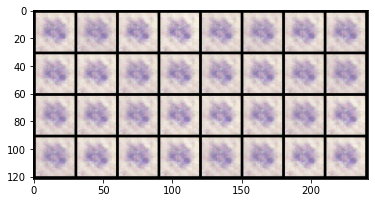

Epoch: [11] [   0/ 146] time: 26.1176, d_loss: 1.31476569, g_loss: 0.77522552
Epoch: [11] [   1/ 146] time: 26.1326, d_loss: 1.41296816, g_loss: 0.79330748
Epoch: [11] [   2/ 146] time: 26.1465, d_loss: 1.40907669, g_loss: 0.77045751
Epoch: [11] [   3/ 146] time: 26.1603, d_loss: 1.37212968, g_loss: 0.75957799
Epoch: [11] [   4/ 146] time: 26.1740, d_loss: 1.27540612, g_loss: 0.77912676
Epoch: [11] [   5/ 146] time: 26.1880, d_loss: 1.45677137, g_loss: 0.75947285
Epoch: [11] [   6/ 146] time: 26.2017, d_loss: 1.38593256, g_loss: 0.75329036
Epoch: [11] [   7/ 146] time: 26.2155, d_loss: 1.37363160, g_loss: 0.76813900
Epoch: [11] [   8/ 146] time: 26.2291, d_loss: 1.40906477, g_loss: 0.77210331
Epoch: [11] [   9/ 146] time: 26.2430, d_loss: 1.31677341, g_loss: 0.79604387
Epoch: [11] [  10/ 146] time: 26.2566, d_loss: 1.35653782, g_loss: 0.78055060
Epoch: [11] [  11/ 146] time: 26.2704, d_loss: 1.39513636, g_loss: 0.78075612
Epoch: [11] [  12/ 146] time: 26.2843, d_loss: 1.39395905, g_los

Epoch: [11] [ 120/ 146] time: 27.7830, d_loss: 1.20565164, g_loss: 0.83455646
Epoch: [11] [ 121/ 146] time: 27.7973, d_loss: 1.24942219, g_loss: 0.82707256
Epoch: [11] [ 122/ 146] time: 27.8115, d_loss: 1.25650775, g_loss: 0.81645298
Epoch: [11] [ 123/ 146] time: 27.8252, d_loss: 1.26922917, g_loss: 0.84053344
Epoch: [11] [ 124/ 146] time: 27.8390, d_loss: 1.32077551, g_loss: 0.81568563
Epoch: [11] [ 125/ 146] time: 27.8527, d_loss: 1.28244662, g_loss: 0.80809718
Epoch: [11] [ 126/ 146] time: 27.8665, d_loss: 1.34004903, g_loss: 0.78307617
Epoch: [11] [ 127/ 146] time: 27.8803, d_loss: 1.23524284, g_loss: 0.78888714
Epoch: [11] [ 128/ 146] time: 27.8942, d_loss: 1.34291804, g_loss: 0.79467010
Epoch: [11] [ 129/ 146] time: 27.9083, d_loss: 1.36639452, g_loss: 0.78370291
Epoch: [11] [ 130/ 146] time: 27.9221, d_loss: 1.30473471, g_loss: 0.79197478
Epoch: [11] [ 131/ 146] time: 27.9359, d_loss: 1.45426667, g_loss: 0.78205276
Epoch: [11] [ 132/ 146] time: 27.9497, d_loss: 1.29564166, g_los

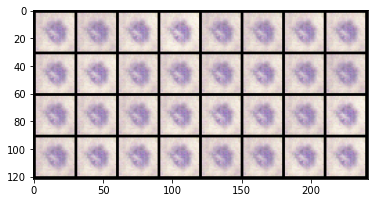

Epoch: [12] [   0/ 146] time: 28.3300, d_loss: 1.28638196, g_loss: 0.78938919
Epoch: [12] [   1/ 146] time: 28.3443, d_loss: 1.26198602, g_loss: 0.78685939
Epoch: [12] [   2/ 146] time: 28.3583, d_loss: 1.35232067, g_loss: 0.79791087
Epoch: [12] [   3/ 146] time: 28.3720, d_loss: 1.38056827, g_loss: 0.76780748
Epoch: [12] [   4/ 146] time: 28.3857, d_loss: 1.43282247, g_loss: 0.76167876
Epoch: [12] [   5/ 146] time: 28.3993, d_loss: 1.43588889, g_loss: 0.75107890
Epoch: [12] [   6/ 146] time: 28.4146, d_loss: 1.29235196, g_loss: 0.77295172
Epoch: [12] [   7/ 146] time: 28.4282, d_loss: 1.33071840, g_loss: 0.80920672
Epoch: [12] [   8/ 146] time: 28.4418, d_loss: 1.29008150, g_loss: 0.82047880
Epoch: [12] [   9/ 146] time: 28.4554, d_loss: 1.33728802, g_loss: 0.82253885
Epoch: [12] [  10/ 146] time: 28.4689, d_loss: 1.30304384, g_loss: 0.83186561
Epoch: [12] [  11/ 146] time: 28.4825, d_loss: 1.25448942, g_loss: 0.83925891
Epoch: [12] [  12/ 146] time: 28.4961, d_loss: 1.31718385, g_los

Epoch: [12] [ 120/ 146] time: 29.9912, d_loss: 1.11733556, g_loss: 0.90761632
Epoch: [12] [ 121/ 146] time: 30.0059, d_loss: 1.11558461, g_loss: 0.89632225
Epoch: [12] [ 122/ 146] time: 30.0199, d_loss: 1.11529732, g_loss: 0.91867286
Epoch: [12] [ 123/ 146] time: 30.0336, d_loss: 1.17575049, g_loss: 0.92704618
Epoch: [12] [ 124/ 146] time: 30.0473, d_loss: 1.16229236, g_loss: 0.92821014
Epoch: [12] [ 125/ 146] time: 30.0609, d_loss: 1.13865447, g_loss: 0.90992391
Epoch: [12] [ 126/ 146] time: 30.0746, d_loss: 1.11500525, g_loss: 0.90400064
Epoch: [12] [ 127/ 146] time: 30.0883, d_loss: 1.09605217, g_loss: 0.92833954
Epoch: [12] [ 128/ 146] time: 30.1020, d_loss: 1.16165352, g_loss: 0.92716658
Epoch: [12] [ 129/ 146] time: 30.1156, d_loss: 1.15354216, g_loss: 0.93567806
Epoch: [12] [ 130/ 146] time: 30.1293, d_loss: 1.06846845, g_loss: 0.97898543
Epoch: [12] [ 131/ 146] time: 30.1429, d_loss: 1.15437424, g_loss: 0.85468614
Epoch: [12] [ 132/ 146] time: 30.1567, d_loss: 1.24372995, g_los

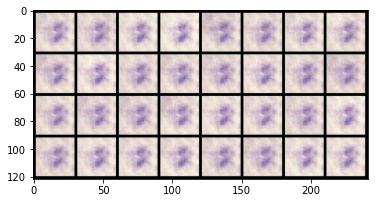

Epoch: [13] [   0/ 146] time: 30.5363, d_loss: 1.24250245, g_loss: 0.79310077
Epoch: [13] [   1/ 146] time: 30.5508, d_loss: 1.21730840, g_loss: 0.86583948
Epoch: [13] [   2/ 146] time: 30.5646, d_loss: 1.12869668, g_loss: 1.03026259
Epoch: [13] [   3/ 146] time: 30.5787, d_loss: 1.06983960, g_loss: 1.01199853
Epoch: [13] [   4/ 146] time: 30.5924, d_loss: 1.06967890, g_loss: 1.03808951
Epoch: [13] [   5/ 146] time: 30.6062, d_loss: 1.04880154, g_loss: 0.97663105
Epoch: [13] [   6/ 146] time: 30.6198, d_loss: 1.21436954, g_loss: 0.82011050
Epoch: [13] [   7/ 146] time: 30.6335, d_loss: 1.15921187, g_loss: 0.84271717
Epoch: [13] [   8/ 146] time: 30.6471, d_loss: 1.11421895, g_loss: 0.95110714
Epoch: [13] [   9/ 146] time: 30.6607, d_loss: 1.21691513, g_loss: 1.01357138
Epoch: [13] [  10/ 146] time: 30.6743, d_loss: 1.12249506, g_loss: 0.99355459
Epoch: [13] [  11/ 146] time: 30.6878, d_loss: 1.24142563, g_loss: 0.89148188
Epoch: [13] [  12/ 146] time: 30.7016, d_loss: 1.16852403, g_los

Epoch: [13] [ 120/ 146] time: 32.2108, d_loss: 0.91750121, g_loss: 1.30544543
Epoch: [13] [ 121/ 146] time: 32.2250, d_loss: 0.78505379, g_loss: 1.64851546
Epoch: [13] [ 122/ 146] time: 32.2394, d_loss: 0.84588683, g_loss: 1.05873883
Epoch: [13] [ 123/ 146] time: 32.2533, d_loss: 1.16113782, g_loss: 0.92985356
Epoch: [13] [ 124/ 146] time: 32.2671, d_loss: 1.14945316, g_loss: 1.01994288
Epoch: [13] [ 125/ 146] time: 32.2808, d_loss: 1.03566837, g_loss: 1.15499544
Epoch: [13] [ 126/ 146] time: 32.2945, d_loss: 1.01346385, g_loss: 1.12501001
Epoch: [13] [ 127/ 146] time: 32.3082, d_loss: 0.89688414, g_loss: 1.02855754
Epoch: [13] [ 128/ 146] time: 32.3220, d_loss: 1.01302540, g_loss: 1.08074951
Epoch: [13] [ 129/ 146] time: 32.3357, d_loss: 0.92443877, g_loss: 1.16224194
Epoch: [13] [ 130/ 146] time: 32.3494, d_loss: 0.89847112, g_loss: 1.29870486
Epoch: [13] [ 131/ 146] time: 32.3631, d_loss: 0.85038006, g_loss: 1.17007089
Epoch: [13] [ 132/ 146] time: 32.3767, d_loss: 1.00265658, g_los

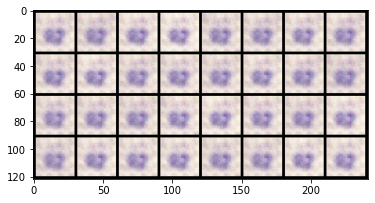

Epoch: [14] [   0/ 146] time: 32.7586, d_loss: 0.94393528, g_loss: 1.28070891
Epoch: [14] [   1/ 146] time: 32.7731, d_loss: 1.11442602, g_loss: 0.86980271
Epoch: [14] [   2/ 146] time: 32.7871, d_loss: 1.16113091, g_loss: 0.90430754
Epoch: [14] [   3/ 146] time: 32.8008, d_loss: 1.02929688, g_loss: 1.12527442
Epoch: [14] [   4/ 146] time: 32.8146, d_loss: 0.96171653, g_loss: 1.26089966
Epoch: [14] [   5/ 146] time: 32.8283, d_loss: 0.78649062, g_loss: 1.38699186
Epoch: [14] [   6/ 146] time: 32.8423, d_loss: 0.75555795, g_loss: 1.12792420
Epoch: [14] [   7/ 146] time: 32.8560, d_loss: 1.00923157, g_loss: 0.96048236
Epoch: [14] [   8/ 146] time: 32.8697, d_loss: 1.00553060, g_loss: 1.08757281
Epoch: [14] [   9/ 146] time: 32.8834, d_loss: 1.07135165, g_loss: 1.18134320
Epoch: [14] [  10/ 146] time: 32.8972, d_loss: 0.87568766, g_loss: 1.23083711
Epoch: [14] [  11/ 146] time: 32.9110, d_loss: 0.99638081, g_loss: 1.02576184
Epoch: [14] [  12/ 146] time: 32.9248, d_loss: 0.99751544, g_los

Epoch: [14] [ 120/ 146] time: 34.4333, d_loss: 1.00695539, g_loss: 1.14771640
Epoch: [14] [ 121/ 146] time: 34.4481, d_loss: 1.03496301, g_loss: 1.13544095
Epoch: [14] [ 122/ 146] time: 34.4621, d_loss: 0.98436439, g_loss: 0.97844338
Epoch: [14] [ 123/ 146] time: 34.4757, d_loss: 1.16174436, g_loss: 0.88527989
Epoch: [14] [ 124/ 146] time: 34.4896, d_loss: 1.16769671, g_loss: 0.99674416
Epoch: [14] [ 125/ 146] time: 34.5032, d_loss: 1.12042069, g_loss: 1.08660281
Epoch: [14] [ 126/ 146] time: 34.5168, d_loss: 1.03727055, g_loss: 1.11166644
Epoch: [14] [ 127/ 146] time: 34.5304, d_loss: 0.94744778, g_loss: 1.02723765
Epoch: [14] [ 128/ 146] time: 34.5443, d_loss: 1.07642972, g_loss: 0.92385089
Epoch: [14] [ 129/ 146] time: 34.5580, d_loss: 1.18366647, g_loss: 0.94919527
Epoch: [14] [ 130/ 146] time: 34.5717, d_loss: 1.13368833, g_loss: 1.01905847
Epoch: [14] [ 131/ 146] time: 34.5853, d_loss: 1.11260068, g_loss: 1.01821256
Epoch: [14] [ 132/ 146] time: 34.5996, d_loss: 0.99955821, g_los

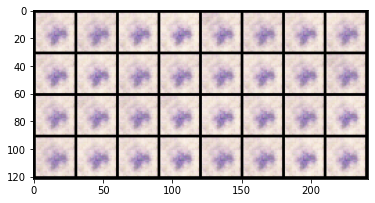

Epoch: [15] [   0/ 146] time: 34.9777, d_loss: 0.91381532, g_loss: 1.03617895
Epoch: [15] [   1/ 146] time: 34.9921, d_loss: 0.99872959, g_loss: 1.03067136
Epoch: [15] [   2/ 146] time: 35.0064, d_loss: 1.07481277, g_loss: 1.02645028
Epoch: [15] [   3/ 146] time: 35.0201, d_loss: 0.96573144, g_loss: 1.08150864
Epoch: [15] [   4/ 146] time: 35.0337, d_loss: 0.90488696, g_loss: 1.13450432
Epoch: [15] [   5/ 146] time: 35.0476, d_loss: 0.96709740, g_loss: 1.04889274
Epoch: [15] [   6/ 146] time: 35.0612, d_loss: 1.07714415, g_loss: 0.95314479
Epoch: [15] [   7/ 146] time: 35.0748, d_loss: 1.16844761, g_loss: 1.06562996
Epoch: [15] [   8/ 146] time: 35.0884, d_loss: 1.00090432, g_loss: 1.09411287
Epoch: [15] [   9/ 146] time: 35.1021, d_loss: 0.96173918, g_loss: 1.05229795
Epoch: [15] [  10/ 146] time: 35.1156, d_loss: 0.89576387, g_loss: 1.06316531
Epoch: [15] [  11/ 146] time: 35.1292, d_loss: 0.86958194, g_loss: 1.11230135
Epoch: [15] [  12/ 146] time: 35.1428, d_loss: 0.86516178, g_los

Epoch: [15] [ 108/ 146] time: 39.4198, d_loss: 1.29805410, g_loss: 1.04113531
Epoch: [15] [ 109/ 146] time: 39.4766, d_loss: 1.12550569, g_loss: 1.34086919
Epoch: [15] [ 110/ 146] time: 39.5302, d_loss: 0.86455369, g_loss: 1.43923068
Epoch: [15] [ 111/ 146] time: 39.5850, d_loss: 0.75482881, g_loss: 1.08242083
Epoch: [15] [ 112/ 146] time: 39.6396, d_loss: 1.23859310, g_loss: 1.09370041
Epoch: [15] [ 113/ 146] time: 39.6961, d_loss: 1.01443613, g_loss: 1.44620264
Epoch: [15] [ 114/ 146] time: 39.7499, d_loss: 0.86272192, g_loss: 1.38964009
Epoch: [15] [ 115/ 146] time: 39.8044, d_loss: 0.83724582, g_loss: 1.02287531
Epoch: [15] [ 116/ 146] time: 39.8591, d_loss: 1.35720849, g_loss: 0.83689994
Epoch: [15] [ 117/ 146] time: 39.9159, d_loss: 1.02486634, g_loss: 1.31180787
Epoch: [15] [ 118/ 146] time: 39.9692, d_loss: 0.80224466, g_loss: 1.47322798
Epoch: [15] [ 119/ 146] time: 40.0238, d_loss: 0.76554322, g_loss: 1.19887781
Epoch: [15] [ 120/ 146] time: 40.0783, d_loss: 0.95685029, g_los

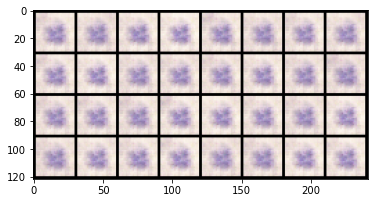

Epoch: [16] [   0/ 146] time: 41.6858, d_loss: 1.01179767, g_loss: 1.28727388
Epoch: [16] [   1/ 146] time: 41.7403, d_loss: 0.95634812, g_loss: 1.41608357
Epoch: [16] [   2/ 146] time: 41.7957, d_loss: 0.82451975, g_loss: 1.16918945
Epoch: [16] [   3/ 146] time: 41.8502, d_loss: 0.86058772, g_loss: 1.12333107
Epoch: [16] [   4/ 146] time: 41.9049, d_loss: 0.93901938, g_loss: 1.20522201
Epoch: [16] [   5/ 146] time: 41.9613, d_loss: 0.96163094, g_loss: 1.31405330
Epoch: [16] [   6/ 146] time: 42.0152, d_loss: 0.96859396, g_loss: 1.15592742
Epoch: [16] [   7/ 146] time: 42.0694, d_loss: 0.97068506, g_loss: 1.01720846
Epoch: [16] [   8/ 146] time: 42.1240, d_loss: 1.01072311, g_loss: 0.99491048
Epoch: [16] [   9/ 146] time: 42.1810, d_loss: 0.94317931, g_loss: 1.30678606
Epoch: [16] [  10/ 146] time: 42.2344, d_loss: 0.88837254, g_loss: 1.36645865
Epoch: [16] [  11/ 146] time: 42.2887, d_loss: 0.75352848, g_loss: 1.35368562
Epoch: [16] [  12/ 146] time: 42.3432, d_loss: 0.97157592, g_los

Epoch: [16] [ 108/ 146] time: 46.3766, d_loss: 0.93879032, g_loss: 1.59480476
Epoch: [16] [ 109/ 146] time: 46.4096, d_loss: 0.68367726, g_loss: 1.71579409
Epoch: [16] [ 110/ 146] time: 46.4378, d_loss: 0.65991813, g_loss: 1.32812715
Epoch: [16] [ 111/ 146] time: 46.4673, d_loss: 0.69412756, g_loss: 1.46432614
Epoch: [16] [ 112/ 146] time: 46.4973, d_loss: 0.62201393, g_loss: 1.68261182
Epoch: [16] [ 113/ 146] time: 46.5284, d_loss: 0.61730903, g_loss: 1.62576509
Epoch: [16] [ 114/ 146] time: 46.5581, d_loss: 0.52431107, g_loss: 1.50908566
Epoch: [16] [ 115/ 146] time: 46.5880, d_loss: 0.59474576, g_loss: 1.75980747
Epoch: [16] [ 116/ 146] time: 46.6199, d_loss: 0.45589206, g_loss: 1.95520139
Epoch: [16] [ 117/ 146] time: 46.6497, d_loss: 0.57102931, g_loss: 1.58913469
Epoch: [16] [ 118/ 146] time: 46.6774, d_loss: 0.68184096, g_loss: 1.52295017
Epoch: [16] [ 119/ 146] time: 46.7066, d_loss: 0.64141035, g_loss: 1.54177952
Epoch: [16] [ 120/ 146] time: 46.7360, d_loss: 0.52818370, g_los

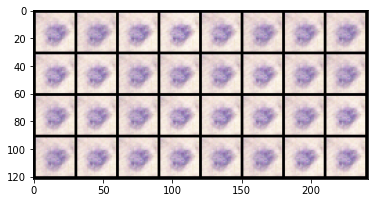

Epoch: [17] [   0/ 146] time: 47.7006, d_loss: 0.84704828, g_loss: 1.13976836
Epoch: [17] [   1/ 146] time: 47.7285, d_loss: 0.92560899, g_loss: 1.17255902
Epoch: [17] [   2/ 146] time: 47.7547, d_loss: 0.93594229, g_loss: 1.28626800
Epoch: [17] [   3/ 146] time: 47.7819, d_loss: 0.93146062, g_loss: 1.26571035
Epoch: [17] [   4/ 146] time: 47.8121, d_loss: 0.90479326, g_loss: 1.08298516
Epoch: [17] [   5/ 146] time: 47.8402, d_loss: 0.91243231, g_loss: 1.21716380
Epoch: [17] [   6/ 146] time: 47.8689, d_loss: 0.94425601, g_loss: 1.32183623
Epoch: [17] [   7/ 146] time: 47.8991, d_loss: 1.06323993, g_loss: 1.13718104
Epoch: [17] [   8/ 146] time: 47.9338, d_loss: 0.99864411, g_loss: 1.00538146
Epoch: [17] [   9/ 146] time: 47.9583, d_loss: 1.01370645, g_loss: 1.15722370
Epoch: [17] [  10/ 146] time: 47.9879, d_loss: 1.04347730, g_loss: 1.18898058
Epoch: [17] [  11/ 146] time: 48.0182, d_loss: 1.17695713, g_loss: 0.96692145
Epoch: [17] [  12/ 146] time: 48.0457, d_loss: 0.94571900, g_los

Epoch: [17] [ 111/ 146] time: 50.9875, d_loss: 0.87419105, g_loss: 1.30277109
Epoch: [17] [ 112/ 146] time: 51.0182, d_loss: 0.89517474, g_loss: 1.33584583
Epoch: [17] [ 113/ 146] time: 51.0461, d_loss: 0.92277026, g_loss: 1.30745828
Epoch: [17] [ 114/ 146] time: 51.0774, d_loss: 0.72154123, g_loss: 1.30747294
Epoch: [17] [ 115/ 146] time: 51.1088, d_loss: 0.72978389, g_loss: 1.51618981
Epoch: [17] [ 116/ 146] time: 51.1362, d_loss: 0.68416011, g_loss: 1.61543608
Epoch: [17] [ 117/ 146] time: 51.1657, d_loss: 0.92343140, g_loss: 1.24101770
Epoch: [17] [ 118/ 146] time: 51.1953, d_loss: 0.77616608, g_loss: 1.29110718
Epoch: [17] [ 119/ 146] time: 51.2290, d_loss: 0.88318706, g_loss: 1.44167137
Epoch: [17] [ 120/ 146] time: 51.2579, d_loss: 0.71451360, g_loss: 1.53612983
Epoch: [17] [ 121/ 146] time: 51.2884, d_loss: 0.73013437, g_loss: 1.36266720
Epoch: [17] [ 122/ 146] time: 51.3181, d_loss: 0.69087225, g_loss: 1.31529307
Epoch: [17] [ 123/ 146] time: 51.3488, d_loss: 0.83396554, g_los

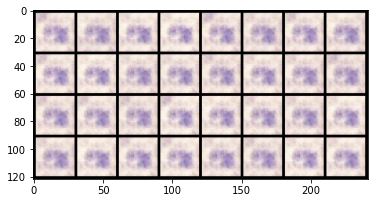

Epoch: [18] [   0/ 146] time: 52.2223, d_loss: 0.75209349, g_loss: 1.35601997
Epoch: [18] [   1/ 146] time: 52.2510, d_loss: 0.85724759, g_loss: 1.33110702
Epoch: [18] [   2/ 146] time: 52.2739, d_loss: 0.79897034, g_loss: 1.43776071
Epoch: [18] [   3/ 146] time: 52.3002, d_loss: 0.58829355, g_loss: 1.60825741
Epoch: [18] [   4/ 146] time: 52.3267, d_loss: 0.67433083, g_loss: 1.45737123
Epoch: [18] [   5/ 146] time: 52.3535, d_loss: 0.75481462, g_loss: 1.24556017
Epoch: [18] [   6/ 146] time: 52.3794, d_loss: 0.83532858, g_loss: 1.37711096
Epoch: [18] [   7/ 146] time: 52.4061, d_loss: 0.69841683, g_loss: 1.69425976
Epoch: [18] [   8/ 146] time: 52.4348, d_loss: 0.63985896, g_loss: 1.54333258
Epoch: [18] [   9/ 146] time: 52.4640, d_loss: 0.58355522, g_loss: 1.43073332
Epoch: [18] [  10/ 146] time: 52.4914, d_loss: 0.69558853, g_loss: 1.30622494
Epoch: [18] [  11/ 146] time: 52.5195, d_loss: 0.67664403, g_loss: 1.52548361
Epoch: [18] [  12/ 146] time: 52.5490, d_loss: 0.69513535, g_los

Epoch: [18] [ 107/ 146] time: 55.3479, d_loss: 1.19617307, g_loss: 1.20796824
Epoch: [18] [ 108/ 146] time: 55.3756, d_loss: 1.04561830, g_loss: 1.16127968
Epoch: [18] [ 109/ 146] time: 55.4051, d_loss: 0.83441699, g_loss: 1.20368588
Epoch: [18] [ 110/ 146] time: 55.4335, d_loss: 0.68298686, g_loss: 1.41639423
Epoch: [18] [ 111/ 146] time: 55.4622, d_loss: 0.75283706, g_loss: 1.61248386
Epoch: [18] [ 112/ 146] time: 55.4915, d_loss: 0.90006852, g_loss: 1.26319551
Epoch: [18] [ 113/ 146] time: 55.5211, d_loss: 1.05402803, g_loss: 1.15139830
Epoch: [18] [ 114/ 146] time: 55.5505, d_loss: 1.00157177, g_loss: 1.44448280
Epoch: [18] [ 115/ 146] time: 55.5811, d_loss: 1.06179762, g_loss: 1.10111618
Epoch: [18] [ 116/ 146] time: 55.6106, d_loss: 1.00202334, g_loss: 0.93770099
Epoch: [18] [ 117/ 146] time: 55.6375, d_loss: 1.33274603, g_loss: 1.10019052
Epoch: [18] [ 118/ 146] time: 55.6653, d_loss: 1.11855268, g_loss: 1.45362496
Epoch: [18] [ 119/ 146] time: 55.6937, d_loss: 0.75500393, g_los

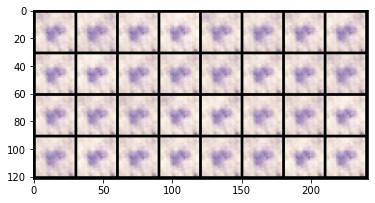

Epoch: [19] [   0/ 146] time: 56.6630, d_loss: 0.87618327, g_loss: 1.13706946
Epoch: [19] [   1/ 146] time: 56.6914, d_loss: 0.81635815, g_loss: 1.33499312
Epoch: [19] [   2/ 146] time: 56.7192, d_loss: 0.69554675, g_loss: 1.66924119
Epoch: [19] [   3/ 146] time: 56.7472, d_loss: 0.67710710, g_loss: 1.42628360
Epoch: [19] [   4/ 146] time: 56.7754, d_loss: 0.57949495, g_loss: 1.42679143
Epoch: [19] [   5/ 146] time: 56.8048, d_loss: 0.72037727, g_loss: 1.53132796
Epoch: [19] [   6/ 146] time: 56.8335, d_loss: 0.80313182, g_loss: 1.51340270
Epoch: [19] [   7/ 146] time: 56.8623, d_loss: 0.77858496, g_loss: 1.38274717
Epoch: [19] [   8/ 146] time: 56.8937, d_loss: 0.78933614, g_loss: 1.42321515
Epoch: [19] [   9/ 146] time: 56.9214, d_loss: 0.64419299, g_loss: 1.34916091
Epoch: [19] [  10/ 146] time: 56.9500, d_loss: 0.67659301, g_loss: 1.50632393
Epoch: [19] [  11/ 146] time: 56.9789, d_loss: 0.60328770, g_loss: 1.70258212
Epoch: [19] [  12/ 146] time: 57.0090, d_loss: 0.63650304, g_los

Epoch: [19] [ 108/ 146] time: 59.8840, d_loss: 0.66459459, g_loss: 1.76936150
Epoch: [19] [ 109/ 146] time: 59.9161, d_loss: 0.73721308, g_loss: 1.38441491
Epoch: [19] [ 110/ 146] time: 59.9462, d_loss: 0.72668725, g_loss: 1.23056269
Epoch: [19] [ 111/ 146] time: 59.9751, d_loss: 0.83891904, g_loss: 1.56026947
Epoch: [19] [ 112/ 146] time: 60.0047, d_loss: 0.70842141, g_loss: 1.76838231
Epoch: [19] [ 113/ 146] time: 60.0352, d_loss: 0.78562820, g_loss: 1.54547942
Epoch: [19] [ 114/ 146] time: 60.0659, d_loss: 0.56374151, g_loss: 1.40809238
Epoch: [19] [ 115/ 146] time: 60.0953, d_loss: 0.59248996, g_loss: 1.42634857
Epoch: [19] [ 116/ 146] time: 60.1284, d_loss: 0.66099942, g_loss: 1.64361548
Epoch: [19] [ 117/ 146] time: 60.1554, d_loss: 0.56958526, g_loss: 1.86936057
Epoch: [19] [ 118/ 146] time: 60.1866, d_loss: 0.64237541, g_loss: 1.65203059
Epoch: [19] [ 119/ 146] time: 60.2161, d_loss: 0.51387936, g_loss: 1.53372741
Epoch: [19] [ 120/ 146] time: 60.2458, d_loss: 0.67255080, g_los

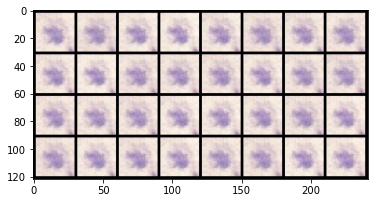

Epoch: [20] [   0/ 146] time: 61.1871, d_loss: 0.76788074, g_loss: 1.44854164
Epoch: [20] [   1/ 146] time: 61.2166, d_loss: 0.80921113, g_loss: 1.27676523
Epoch: [20] [   2/ 146] time: 61.2776, d_loss: 0.68988419, g_loss: 1.43561161
Epoch: [20] [   3/ 146] time: 61.3336, d_loss: 0.75531614, g_loss: 1.45386612
Epoch: [20] [   4/ 146] time: 61.3885, d_loss: 0.73272991, g_loss: 1.38668406
Epoch: [20] [   5/ 146] time: 61.4442, d_loss: 0.79076868, g_loss: 1.26145792
Epoch: [20] [   6/ 146] time: 61.5017, d_loss: 0.85757005, g_loss: 1.38071024
Epoch: [20] [   7/ 146] time: 61.5536, d_loss: 0.81563723, g_loss: 1.48325181
Epoch: [20] [   8/ 146] time: 61.6089, d_loss: 0.73536468, g_loss: 1.39732838
Epoch: [20] [   9/ 146] time: 61.6644, d_loss: 0.88581485, g_loss: 1.18404067
Epoch: [20] [  10/ 146] time: 61.7182, d_loss: 0.72099817, g_loss: 1.33701897
Epoch: [20] [  11/ 146] time: 61.7722, d_loss: 0.79614484, g_loss: 1.45851851
Epoch: [20] [  12/ 146] time: 61.8271, d_loss: 0.76047397, g_los

Epoch: [20] [ 109/ 146] time: 67.1452, d_loss: 0.73422468, g_loss: 1.53910208
Epoch: [20] [ 110/ 146] time: 67.2018, d_loss: 0.60868776, g_loss: 1.79336584
Epoch: [20] [ 111/ 146] time: 67.2554, d_loss: 0.79225117, g_loss: 1.40317583
Epoch: [20] [ 112/ 146] time: 67.3099, d_loss: 0.83167166, g_loss: 1.10836864
Epoch: [20] [ 113/ 146] time: 67.3643, d_loss: 0.84314072, g_loss: 1.51362109
Epoch: [20] [ 114/ 146] time: 67.4210, d_loss: 0.73653972, g_loss: 1.75185859
Epoch: [20] [ 115/ 146] time: 67.4750, d_loss: 0.68151289, g_loss: 1.52395439
Epoch: [20] [ 116/ 146] time: 67.5294, d_loss: 0.58449686, g_loss: 1.38652718
Epoch: [20] [ 117/ 146] time: 67.5838, d_loss: 0.66519982, g_loss: 1.67363501
Epoch: [20] [ 118/ 146] time: 67.6408, d_loss: 0.72101688, g_loss: 1.46741402
Epoch: [20] [ 119/ 146] time: 67.6951, d_loss: 0.77898508, g_loss: 1.33164716
Epoch: [20] [ 120/ 146] time: 67.7499, d_loss: 0.66789877, g_loss: 1.59734452
Epoch: [20] [ 121/ 146] time: 67.8035, d_loss: 0.68735015, g_los

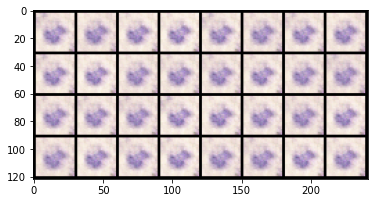

Epoch: [21] [   0/ 146] time: 69.3556, d_loss: 0.75402081, g_loss: 1.51586437
Epoch: [21] [   1/ 146] time: 69.3977, d_loss: 0.89132088, g_loss: 0.99026191
Epoch: [21] [   2/ 146] time: 69.4252, d_loss: 0.87074965, g_loss: 1.47517180
Epoch: [21] [   3/ 146] time: 69.4530, d_loss: 0.66574609, g_loss: 1.82561338
Epoch: [21] [   4/ 146] time: 69.4811, d_loss: 0.75469935, g_loss: 1.51349032
Epoch: [21] [   5/ 146] time: 69.5085, d_loss: 0.56055140, g_loss: 1.32858443
Epoch: [21] [   6/ 146] time: 69.5368, d_loss: 0.90769714, g_loss: 1.13934946
Epoch: [21] [   7/ 146] time: 69.5655, d_loss: 0.92585808, g_loss: 1.40164030
Epoch: [21] [   8/ 146] time: 69.5961, d_loss: 0.85765839, g_loss: 1.41076255
Epoch: [21] [   9/ 146] time: 69.6256, d_loss: 0.81496108, g_loss: 1.31095898
Epoch: [21] [  10/ 146] time: 69.6532, d_loss: 0.71649754, g_loss: 1.39188790
Epoch: [21] [  11/ 146] time: 69.6818, d_loss: 0.69422060, g_loss: 1.43722749
Epoch: [21] [  12/ 146] time: 69.7113, d_loss: 0.69579649, g_los

Epoch: [21] [ 108/ 146] time: 72.5190, d_loss: 0.35586685, g_loss: 1.80645299
Epoch: [21] [ 109/ 146] time: 72.5465, d_loss: 0.49930418, g_loss: 1.75473583
Epoch: [21] [ 110/ 146] time: 72.5752, d_loss: 0.44055736, g_loss: 2.03925896
Epoch: [21] [ 111/ 146] time: 72.6042, d_loss: 0.50893253, g_loss: 1.82678628
Epoch: [21] [ 112/ 146] time: 72.6344, d_loss: 0.42365244, g_loss: 1.86335564
Epoch: [21] [ 113/ 146] time: 72.6636, d_loss: 0.41332948, g_loss: 1.83925593
Epoch: [21] [ 114/ 146] time: 72.6928, d_loss: 0.44473779, g_loss: 1.68521929
Epoch: [21] [ 115/ 146] time: 72.7224, d_loss: 0.47314575, g_loss: 1.69253612
Epoch: [21] [ 116/ 146] time: 72.7517, d_loss: 0.52984476, g_loss: 1.82534647
Epoch: [21] [ 117/ 146] time: 72.7798, d_loss: 0.59487784, g_loss: 1.67078638
Epoch: [21] [ 118/ 146] time: 72.8089, d_loss: 0.47605753, g_loss: 1.72281063
Epoch: [21] [ 119/ 146] time: 72.8392, d_loss: 0.34667870, g_loss: 2.10654116
Epoch: [21] [ 120/ 146] time: 72.8681, d_loss: 0.36820287, g_los

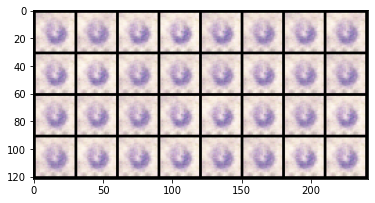

Epoch: [22] [   0/ 146] time: 73.8287, d_loss: 0.56582206, g_loss: 1.66639018
Epoch: [22] [   1/ 146] time: 73.8564, d_loss: 0.48403424, g_loss: 1.77496195
Epoch: [22] [   2/ 146] time: 73.8789, d_loss: 0.54248816, g_loss: 1.95581877
Epoch: [22] [   3/ 146] time: 73.9013, d_loss: 0.52378321, g_loss: 2.00719976
Epoch: [22] [   4/ 146] time: 73.9245, d_loss: 0.69325900, g_loss: 1.37134755
Epoch: [22] [   5/ 146] time: 73.9504, d_loss: 0.86211228, g_loss: 1.58396494
Epoch: [22] [   6/ 146] time: 73.9772, d_loss: 0.81819701, g_loss: 1.57132983
Epoch: [22] [   7/ 146] time: 74.0046, d_loss: 0.84735733, g_loss: 1.14351797
Epoch: [22] [   8/ 146] time: 74.0311, d_loss: 0.92122680, g_loss: 1.37606788
Epoch: [22] [   9/ 146] time: 74.0601, d_loss: 0.68699801, g_loss: 1.76511097
Epoch: [22] [  10/ 146] time: 74.0881, d_loss: 0.90194082, g_loss: 1.23487937
Epoch: [22] [  11/ 146] time: 74.1139, d_loss: 0.69256794, g_loss: 1.39244437
Epoch: [22] [  12/ 146] time: 74.1406, d_loss: 0.62316358, g_los

Epoch: [22] [ 109/ 146] time: 76.9717, d_loss: 0.83325225, g_loss: 1.07148433
Epoch: [22] [ 110/ 146] time: 77.0043, d_loss: 0.73847252, g_loss: 1.69197655
Epoch: [22] [ 111/ 146] time: 77.0327, d_loss: 0.55549216, g_loss: 2.18211842
Epoch: [22] [ 112/ 146] time: 77.0623, d_loss: 0.55606025, g_loss: 1.93432140
Epoch: [22] [ 113/ 146] time: 77.0903, d_loss: 0.57232475, g_loss: 1.48341691
Epoch: [22] [ 114/ 146] time: 77.1186, d_loss: 0.61523318, g_loss: 1.82441318
Epoch: [22] [ 115/ 146] time: 77.1467, d_loss: 0.66490448, g_loss: 1.61427212
Epoch: [22] [ 116/ 146] time: 77.1756, d_loss: 0.49706501, g_loss: 1.58505034
Epoch: [22] [ 117/ 146] time: 77.2058, d_loss: 0.66904372, g_loss: 1.59799504
Epoch: [22] [ 118/ 146] time: 77.2333, d_loss: 0.64384037, g_loss: 1.69306445
Epoch: [22] [ 119/ 146] time: 77.2625, d_loss: 0.48829949, g_loss: 1.91708934
Epoch: [22] [ 120/ 146] time: 77.2897, d_loss: 0.54746604, g_loss: 1.73130882
Epoch: [22] [ 121/ 146] time: 77.3182, d_loss: 0.66470468, g_los

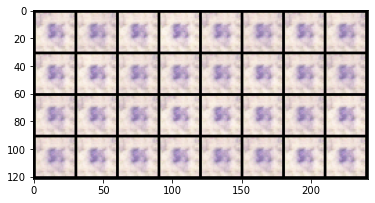

Epoch: [23] [   0/ 146] time: 78.2249, d_loss: 0.61132503, g_loss: 2.04282475
Epoch: [23] [   1/ 146] time: 78.2525, d_loss: 0.35695225, g_loss: 1.89941478
Epoch: [23] [   2/ 146] time: 78.2963, d_loss: 0.55153894, g_loss: 1.78426743
Epoch: [23] [   3/ 146] time: 78.3255, d_loss: 0.46917346, g_loss: 2.08890462
Epoch: [23] [   4/ 146] time: 78.3721, d_loss: 0.46951711, g_loss: 1.88073099
Epoch: [23] [   5/ 146] time: 78.4012, d_loss: 0.35905689, g_loss: 1.79269338
Epoch: [23] [   6/ 146] time: 78.4459, d_loss: 0.42646551, g_loss: 1.99362552
Epoch: [23] [   7/ 146] time: 78.4781, d_loss: 0.36084273, g_loss: 2.26613140
Epoch: [23] [   8/ 146] time: 78.5200, d_loss: 0.47482717, g_loss: 1.66152620
Epoch: [23] [   9/ 146] time: 78.5565, d_loss: 0.41413003, g_loss: 1.71555352
Epoch: [23] [  10/ 146] time: 78.5975, d_loss: 0.41244116, g_loss: 2.14749765
Epoch: [23] [  11/ 146] time: 78.6350, d_loss: 0.36719513, g_loss: 2.33028555
Epoch: [23] [  12/ 146] time: 78.6755, d_loss: 0.39752829, g_los

Epoch: [23] [ 109/ 146] time: 83.9590, d_loss: 0.60038817, g_loss: 1.57238746
Epoch: [23] [ 110/ 146] time: 84.0157, d_loss: 0.63760626, g_loss: 1.50894094
Epoch: [23] [ 111/ 146] time: 84.0695, d_loss: 0.63563347, g_loss: 1.65046883
Epoch: [23] [ 112/ 146] time: 84.1240, d_loss: 0.57997906, g_loss: 1.85835028
Epoch: [23] [ 113/ 146] time: 84.1782, d_loss: 0.73670983, g_loss: 1.36486077
Epoch: [23] [ 114/ 146] time: 84.2348, d_loss: 0.56880581, g_loss: 1.60526299
Epoch: [23] [ 115/ 146] time: 84.2884, d_loss: 0.50176162, g_loss: 1.96296346
Epoch: [23] [ 116/ 146] time: 84.3434, d_loss: 0.67978239, g_loss: 1.44157958
Epoch: [23] [ 117/ 146] time: 84.3977, d_loss: 0.75376272, g_loss: 1.59114051
Epoch: [23] [ 118/ 146] time: 84.4540, d_loss: 0.55847627, g_loss: 2.17805958
Epoch: [23] [ 119/ 146] time: 84.5081, d_loss: 0.55200952, g_loss: 2.15043759
Epoch: [23] [ 120/ 146] time: 84.5627, d_loss: 0.35144168, g_loss: 1.91621137
Epoch: [23] [ 121/ 146] time: 84.6172, d_loss: 0.49366403, g_los

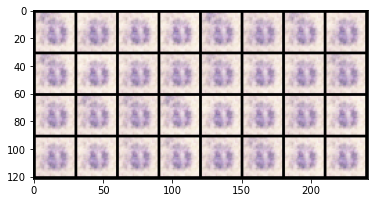

Epoch: [24] [   0/ 146] time: 86.1699, d_loss: 0.32942590, g_loss: 1.96658218
Epoch: [24] [   1/ 146] time: 86.2240, d_loss: 0.49968699, g_loss: 1.59747469
Epoch: [24] [   2/ 146] time: 86.2791, d_loss: 0.43994606, g_loss: 1.62762976
Epoch: [24] [   3/ 146] time: 86.3336, d_loss: 0.42631102, g_loss: 2.09226751
Epoch: [24] [   4/ 146] time: 86.3883, d_loss: 0.41694701, g_loss: 2.06621313
Epoch: [24] [   5/ 146] time: 86.4457, d_loss: 0.42105496, g_loss: 1.94856203
Epoch: [24] [   6/ 146] time: 86.4994, d_loss: 0.43765947, g_loss: 1.72477841
Epoch: [24] [   7/ 146] time: 86.5534, d_loss: 0.45170373, g_loss: 1.75116909
Epoch: [24] [   8/ 146] time: 86.6080, d_loss: 0.34179670, g_loss: 2.17035389
Epoch: [24] [   9/ 146] time: 86.6643, d_loss: 0.38680440, g_loss: 2.04716444
Epoch: [24] [  10/ 146] time: 86.7186, d_loss: 0.24989510, g_loss: 2.20117426
Epoch: [24] [  11/ 146] time: 86.7731, d_loss: 0.29374900, g_loss: 1.97977948
Epoch: [24] [  12/ 146] time: 86.8276, d_loss: 0.37713858, g_los

Epoch: [24] [ 108/ 146] time: 92.0878, d_loss: 0.30682617, g_loss: 2.06811237
Epoch: [24] [ 109/ 146] time: 92.1448, d_loss: 0.36941135, g_loss: 2.10096693
Epoch: [24] [ 110/ 146] time: 92.1985, d_loss: 0.32477286, g_loss: 2.36505318
Epoch: [24] [ 111/ 146] time: 92.2531, d_loss: 0.24863219, g_loss: 2.53611851
Epoch: [24] [ 112/ 146] time: 92.3078, d_loss: 0.25637770, g_loss: 2.48598552
Epoch: [24] [ 113/ 146] time: 92.3643, d_loss: 0.17738789, g_loss: 2.28156114
Epoch: [24] [ 114/ 146] time: 92.4180, d_loss: 0.46113166, g_loss: 2.03381181
Epoch: [24] [ 115/ 146] time: 92.4725, d_loss: 0.45367169, g_loss: 2.58397150
Epoch: [24] [ 116/ 146] time: 92.5273, d_loss: 0.63325906, g_loss: 1.94949889
Epoch: [24] [ 117/ 146] time: 92.5840, d_loss: 0.50531024, g_loss: 1.43217897
Epoch: [24] [ 118/ 146] time: 92.6379, d_loss: 0.61002719, g_loss: 1.96593809
Epoch: [24] [ 119/ 146] time: 92.6920, d_loss: 0.49303138, g_loss: 2.08231020
Epoch: [24] [ 120/ 146] time: 92.7465, d_loss: 0.27862853, g_los

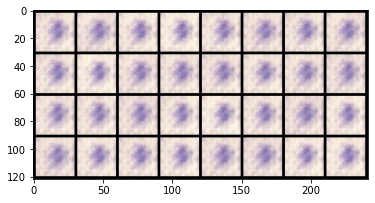

Epoch: [25] [   0/ 146] time: 94.3549, d_loss: 0.42952028, g_loss: 2.15394878
Epoch: [25] [   1/ 146] time: 94.4220, d_loss: 0.59074926, g_loss: 1.63804090
Epoch: [25] [   2/ 146] time: 94.4834, d_loss: 0.64167130, g_loss: 1.52830756
Epoch: [25] [   3/ 146] time: 94.5380, d_loss: 0.72495532, g_loss: 1.61795092
Epoch: [25] [   4/ 146] time: 94.5926, d_loss: 0.60531700, g_loss: 2.07616425
Epoch: [25] [   5/ 146] time: 94.6493, d_loss: 0.57318842, g_loss: 1.82595181
Epoch: [25] [   6/ 146] time: 94.7024, d_loss: 0.47736335, g_loss: 1.55312514
Epoch: [25] [   7/ 146] time: 94.7564, d_loss: 0.48561272, g_loss: 1.85231757
Epoch: [25] [   8/ 146] time: 94.8107, d_loss: 0.56321079, g_loss: 1.55455530
Epoch: [25] [   9/ 146] time: 94.8675, d_loss: 0.49483404, g_loss: 1.85406363
Epoch: [25] [  10/ 146] time: 94.9215, d_loss: 0.43820310, g_loss: 2.44782805
Epoch: [25] [  11/ 146] time: 94.9758, d_loss: 0.43344167, g_loss: 2.21378469
Epoch: [25] [  12/ 146] time: 95.0322, d_loss: 0.53799474, g_los

Epoch: [25] [ 106/ 146] time: 100.1457, d_loss: 0.93316197, g_loss: 1.59873033
Epoch: [25] [ 107/ 146] time: 100.2027, d_loss: 0.71349663, g_loss: 1.41972625
Epoch: [25] [ 108/ 146] time: 100.2562, d_loss: 0.64514887, g_loss: 1.77522409
Epoch: [25] [ 109/ 146] time: 100.3106, d_loss: 0.63523716, g_loss: 1.81214154
Epoch: [25] [ 110/ 146] time: 100.3649, d_loss: 0.51459825, g_loss: 1.58216214
Epoch: [25] [ 111/ 146] time: 100.4220, d_loss: 0.63005209, g_loss: 1.75924969
Epoch: [25] [ 112/ 146] time: 100.4756, d_loss: 0.57966912, g_loss: 1.94557667
Epoch: [25] [ 113/ 146] time: 100.5303, d_loss: 0.39574727, g_loss: 2.11451817
Epoch: [25] [ 114/ 146] time: 100.5848, d_loss: 0.72990936, g_loss: 1.52370691
Epoch: [25] [ 115/ 146] time: 100.6412, d_loss: 0.73585594, g_loss: 1.85731637
Epoch: [25] [ 116/ 146] time: 100.6955, d_loss: 0.49202290, g_loss: 2.03923798
Epoch: [25] [ 117/ 146] time: 100.7497, d_loss: 0.44254330, g_loss: 2.14610982
Epoch: [25] [ 118/ 146] time: 100.8040, d_loss: 0.40

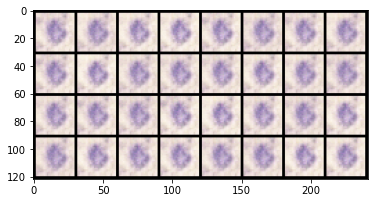

Epoch: [26] [   0/ 146] time: 102.4174, d_loss: 0.91405946, g_loss: 1.56434417
Epoch: [26] [   1/ 146] time: 102.4474, d_loss: 0.50551856, g_loss: 1.55009437
Epoch: [26] [   2/ 146] time: 102.4736, d_loss: 0.50285953, g_loss: 2.21555352
Epoch: [26] [   3/ 146] time: 102.5003, d_loss: 0.41414127, g_loss: 2.27881145
Epoch: [26] [   4/ 146] time: 102.5275, d_loss: 0.31615543, g_loss: 2.46771765
Epoch: [26] [   5/ 146] time: 102.5543, d_loss: 0.37615550, g_loss: 2.02002788
Epoch: [26] [   6/ 146] time: 102.5818, d_loss: 0.36845276, g_loss: 2.01949239
Epoch: [26] [   7/ 146] time: 102.6109, d_loss: 0.63203549, g_loss: 1.77879858
Epoch: [26] [   8/ 146] time: 102.6408, d_loss: 0.53973049, g_loss: 1.87357688
Epoch: [26] [   9/ 146] time: 102.6689, d_loss: 0.39674258, g_loss: 2.10206175
Epoch: [26] [  10/ 146] time: 102.6977, d_loss: 0.41049454, g_loss: 1.88415742
Epoch: [26] [  11/ 146] time: 102.7271, d_loss: 0.45744970, g_loss: 1.89036942
Epoch: [26] [  12/ 146] time: 102.7543, d_loss: 0.44

Epoch: [26] [ 110/ 146] time: 105.7528, d_loss: 0.45243245, g_loss: 2.16689682
Epoch: [26] [ 111/ 146] time: 105.7802, d_loss: 0.56475246, g_loss: 1.89333653
Epoch: [26] [ 112/ 146] time: 105.8082, d_loss: 0.50155842, g_loss: 1.74240077
Epoch: [26] [ 113/ 146] time: 105.8383, d_loss: 0.53495908, g_loss: 1.83828807
Epoch: [26] [ 114/ 146] time: 105.8675, d_loss: 0.49109751, g_loss: 2.12553978
Epoch: [26] [ 115/ 146] time: 105.8962, d_loss: 0.69115597, g_loss: 1.50836396
Epoch: [26] [ 116/ 146] time: 105.9255, d_loss: 0.76060379, g_loss: 1.49004805
Epoch: [26] [ 117/ 146] time: 105.9550, d_loss: 0.60826743, g_loss: 1.81315279
Epoch: [26] [ 118/ 146] time: 105.9859, d_loss: 0.75797999, g_loss: 1.55050457
Epoch: [26] [ 119/ 146] time: 106.0134, d_loss: 0.56236905, g_loss: 1.80330980
Epoch: [26] [ 120/ 146] time: 106.0423, d_loss: 0.62434244, g_loss: 1.71138418
Epoch: [26] [ 121/ 146] time: 106.0692, d_loss: 0.69791389, g_loss: 1.59675395
Epoch: [26] [ 122/ 146] time: 106.0969, d_loss: 0.62

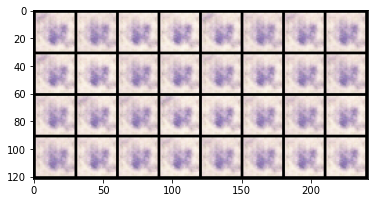

Epoch: [27] [   0/ 146] time: 106.9892, d_loss: 0.50278676, g_loss: 2.30113912
Epoch: [27] [   1/ 146] time: 107.0146, d_loss: 0.57626313, g_loss: 1.86292171
Epoch: [27] [   2/ 146] time: 107.0412, d_loss: 0.55136549, g_loss: 1.67846191
Epoch: [27] [   3/ 146] time: 107.0678, d_loss: 0.53025496, g_loss: 1.61510170
Epoch: [27] [   4/ 146] time: 107.0939, d_loss: 0.51583332, g_loss: 1.67778301
Epoch: [27] [   5/ 146] time: 107.1225, d_loss: 0.34656924, g_loss: 2.06601501
Epoch: [27] [   6/ 146] time: 107.1498, d_loss: 0.44746751, g_loss: 2.04195499
Epoch: [27] [   7/ 146] time: 107.1775, d_loss: 0.30156368, g_loss: 2.30446482
Epoch: [27] [   8/ 146] time: 107.2070, d_loss: 0.37032342, g_loss: 2.24807978
Epoch: [27] [   9/ 146] time: 107.2331, d_loss: 0.25581092, g_loss: 2.28815651
Epoch: [27] [  10/ 146] time: 107.2608, d_loss: 0.36586782, g_loss: 2.07662058
Epoch: [27] [  11/ 146] time: 107.2891, d_loss: 0.34790778, g_loss: 2.13271523
Epoch: [27] [  12/ 146] time: 107.3158, d_loss: 0.41

Epoch: [27] [ 107/ 146] time: 110.0950, d_loss: 0.55115420, g_loss: 1.40284431
Epoch: [27] [ 108/ 146] time: 110.1188, d_loss: 0.67778778, g_loss: 2.10400677
Epoch: [27] [ 109/ 146] time: 110.1472, d_loss: 0.52560008, g_loss: 2.11746168
Epoch: [27] [ 110/ 146] time: 110.1851, d_loss: 0.52336597, g_loss: 1.91931820
Epoch: [27] [ 111/ 146] time: 110.2144, d_loss: 0.38640258, g_loss: 2.09706187
Epoch: [27] [ 112/ 146] time: 110.2454, d_loss: 0.34642529, g_loss: 2.27524042
Epoch: [27] [ 113/ 146] time: 110.2703, d_loss: 0.31504798, g_loss: 2.23735309
Epoch: [27] [ 114/ 146] time: 110.3039, d_loss: 0.44664299, g_loss: 1.91381001
Epoch: [27] [ 115/ 146] time: 110.3346, d_loss: 0.47933707, g_loss: 1.68410993
Epoch: [27] [ 116/ 146] time: 110.3677, d_loss: 0.61042941, g_loss: 1.77687979
Epoch: [27] [ 117/ 146] time: 110.3942, d_loss: 0.56126499, g_loss: 1.85058284
Epoch: [27] [ 118/ 146] time: 110.4224, d_loss: 0.52985632, g_loss: 1.89384413
Epoch: [27] [ 119/ 146] time: 110.4509, d_loss: 0.30

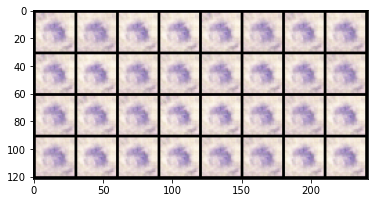

Epoch: [28] [   0/ 146] time: 111.4410, d_loss: 0.51502615, g_loss: 2.00244856
Epoch: [28] [   1/ 146] time: 111.4680, d_loss: 0.54370970, g_loss: 1.54249001
Epoch: [28] [   2/ 146] time: 111.4958, d_loss: 0.88541913, g_loss: 1.30868542
Epoch: [28] [   3/ 146] time: 111.5245, d_loss: 0.76403868, g_loss: 1.43412948
Epoch: [28] [   4/ 146] time: 111.5548, d_loss: 0.80092150, g_loss: 1.59476566
Epoch: [28] [   5/ 146] time: 111.5871, d_loss: 0.52584970, g_loss: 2.09902167
Epoch: [28] [   6/ 146] time: 111.6150, d_loss: 0.74007314, g_loss: 1.23731518
Epoch: [28] [   7/ 146] time: 111.6433, d_loss: 0.61706865, g_loss: 1.82112598
Epoch: [28] [   8/ 146] time: 111.6788, d_loss: 0.65851331, g_loss: 1.65989530
Epoch: [28] [   9/ 146] time: 111.7071, d_loss: 0.68489933, g_loss: 1.42921495
Epoch: [28] [  10/ 146] time: 111.7350, d_loss: 0.71597970, g_loss: 1.62170362
Epoch: [28] [  11/ 146] time: 111.7577, d_loss: 0.53131425, g_loss: 2.11647916
Epoch: [28] [  12/ 146] time: 111.7863, d_loss: 0.70

Epoch: [28] [ 107/ 146] time: 114.5389, d_loss: 0.54705817, g_loss: 1.98126113
Epoch: [28] [ 108/ 146] time: 114.5688, d_loss: 0.48537898, g_loss: 1.68705451
Epoch: [28] [ 109/ 146] time: 114.5995, d_loss: 0.41287345, g_loss: 1.81320715
Epoch: [28] [ 110/ 146] time: 114.6286, d_loss: 0.47198027, g_loss: 2.04048920
Epoch: [28] [ 111/ 146] time: 114.6583, d_loss: 0.46907765, g_loss: 1.71889448
Epoch: [28] [ 112/ 146] time: 114.6885, d_loss: 0.53745687, g_loss: 1.93143463
Epoch: [28] [ 113/ 146] time: 114.7175, d_loss: 0.59204817, g_loss: 1.86838377
Epoch: [28] [ 114/ 146] time: 114.7463, d_loss: 0.55210245, g_loss: 1.88123131
Epoch: [28] [ 115/ 146] time: 114.7776, d_loss: 0.49483740, g_loss: 1.82416606
Epoch: [28] [ 116/ 146] time: 114.8067, d_loss: 0.54003239, g_loss: 1.49152493
Epoch: [28] [ 117/ 146] time: 114.8358, d_loss: 0.74809921, g_loss: 1.61514986
Epoch: [28] [ 118/ 146] time: 114.8648, d_loss: 0.57902443, g_loss: 2.21108007
Epoch: [28] [ 119/ 146] time: 114.8936, d_loss: 0.78

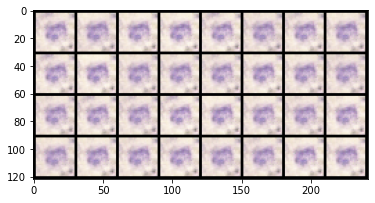

Epoch: [29] [   0/ 146] time: 115.8604, d_loss: 0.52023113, g_loss: 1.56835604
Epoch: [29] [   1/ 146] time: 115.8873, d_loss: 0.56057453, g_loss: 1.72302389
Epoch: [29] [   2/ 146] time: 115.9097, d_loss: 0.44704205, g_loss: 2.14216518
Epoch: [29] [   3/ 146] time: 115.9359, d_loss: 0.47038478, g_loss: 1.95218778
Epoch: [29] [   4/ 146] time: 115.9608, d_loss: 0.29682609, g_loss: 1.93704724
Epoch: [29] [   5/ 146] time: 115.9876, d_loss: 0.40466413, g_loss: 2.01440907
Epoch: [29] [   6/ 146] time: 116.0131, d_loss: 0.43532932, g_loss: 2.10121298
Epoch: [29] [   7/ 146] time: 116.0387, d_loss: 0.50970554, g_loss: 1.87580562
Epoch: [29] [   8/ 146] time: 116.0661, d_loss: 0.47497228, g_loss: 1.43285942
Epoch: [29] [   9/ 146] time: 116.0951, d_loss: 0.70775038, g_loss: 2.03929663
Epoch: [29] [  10/ 146] time: 116.1214, d_loss: 0.49736655, g_loss: 2.27803183
Epoch: [29] [  11/ 146] time: 116.1498, d_loss: 0.45795870, g_loss: 1.94636810
Epoch: [29] [  12/ 146] time: 116.1766, d_loss: 0.36

Epoch: [29] [ 107/ 146] time: 118.9824, d_loss: 0.51667094, g_loss: 1.93327188
Epoch: [29] [ 108/ 146] time: 119.0127, d_loss: 0.43324733, g_loss: 2.05946636
Epoch: [29] [ 109/ 146] time: 119.0418, d_loss: 0.38978055, g_loss: 2.04926825
Epoch: [29] [ 110/ 146] time: 119.0691, d_loss: 0.40229705, g_loss: 1.90315652
Epoch: [29] [ 111/ 146] time: 119.0961, d_loss: 0.45557073, g_loss: 1.76376128
Epoch: [29] [ 112/ 146] time: 119.1245, d_loss: 0.52039349, g_loss: 1.67263174
Epoch: [29] [ 113/ 146] time: 119.1510, d_loss: 0.44531402, g_loss: 2.19864511
Epoch: [29] [ 114/ 146] time: 119.1788, d_loss: 0.48649770, g_loss: 2.00951529
Epoch: [29] [ 115/ 146] time: 119.2091, d_loss: 0.51287091, g_loss: 1.70137906
Epoch: [29] [ 116/ 146] time: 119.2373, d_loss: 0.51311815, g_loss: 1.73176622
Epoch: [29] [ 117/ 146] time: 119.2660, d_loss: 0.41940784, g_loss: 2.05724573
Epoch: [29] [ 118/ 146] time: 119.2948, d_loss: 0.30172861, g_loss: 2.35708141
Epoch: [29] [ 119/ 146] time: 119.3248, d_loss: 0.46

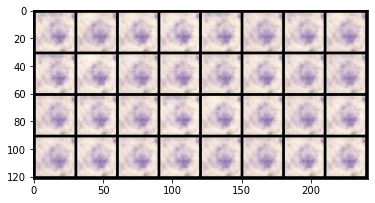

Epoch: [30] [   0/ 146] time: 120.3135, d_loss: 0.25383705, g_loss: 2.10894752
Epoch: [30] [   1/ 146] time: 120.3425, d_loss: 0.48187998, g_loss: 2.13582754
Epoch: [30] [   2/ 146] time: 120.3682, d_loss: 0.39950448, g_loss: 2.34262896
Epoch: [30] [   3/ 146] time: 120.3940, d_loss: 0.43829325, g_loss: 1.98610687
Epoch: [30] [   4/ 146] time: 120.4235, d_loss: 0.38005507, g_loss: 1.58370721
Epoch: [30] [   5/ 146] time: 120.4524, d_loss: 0.40621743, g_loss: 2.32119274
Epoch: [30] [   6/ 146] time: 120.4815, d_loss: 0.33563676, g_loss: 2.55570292
Epoch: [30] [   7/ 146] time: 120.5117, d_loss: 0.32802451, g_loss: 2.36394882
Epoch: [30] [   8/ 146] time: 120.5398, d_loss: 0.25899678, g_loss: 2.09800291
Epoch: [30] [   9/ 146] time: 120.5694, d_loss: 0.39948690, g_loss: 2.09819841
Epoch: [30] [  10/ 146] time: 120.5984, d_loss: 0.36199552, g_loss: 2.30930519
Epoch: [30] [  11/ 146] time: 120.6279, d_loss: 0.39791262, g_loss: 2.18476534
Epoch: [30] [  12/ 146] time: 120.6561, d_loss: 0.32

Epoch: [30] [ 110/ 146] time: 123.4910, d_loss: 0.43122125, g_loss: 2.52163076
Epoch: [30] [ 111/ 146] time: 123.5210, d_loss: 0.44635400, g_loss: 2.13208294
Epoch: [30] [ 112/ 146] time: 123.5483, d_loss: 0.58613455, g_loss: 1.47005558
Epoch: [30] [ 113/ 146] time: 123.5768, d_loss: 0.48806900, g_loss: 1.84239626
Epoch: [30] [ 114/ 146] time: 123.6061, d_loss: 0.39313388, g_loss: 2.28120685
Epoch: [30] [ 115/ 146] time: 123.6358, d_loss: 0.46426624, g_loss: 1.99205673
Epoch: [30] [ 116/ 146] time: 123.6650, d_loss: 0.53562808, g_loss: 1.60777485
Epoch: [30] [ 117/ 146] time: 123.6942, d_loss: 0.54924297, g_loss: 2.05146646
Epoch: [30] [ 118/ 146] time: 123.7259, d_loss: 0.39991993, g_loss: 2.33238721
Epoch: [30] [ 119/ 146] time: 123.7533, d_loss: 0.43937436, g_loss: 2.06593609
Epoch: [30] [ 120/ 146] time: 123.7812, d_loss: 0.49810421, g_loss: 1.67674446
Epoch: [30] [ 121/ 146] time: 123.8099, d_loss: 0.50450504, g_loss: 1.69606197
Epoch: [30] [ 122/ 146] time: 123.8390, d_loss: 0.42

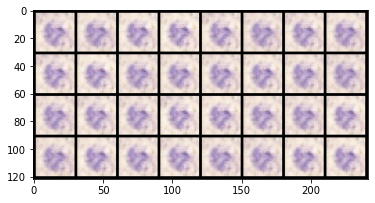

Epoch: [31] [   0/ 146] time: 124.7199, d_loss: 0.42964619, g_loss: 1.75690460
Epoch: [31] [   1/ 146] time: 124.7499, d_loss: 0.60797781, g_loss: 1.85283947
Epoch: [31] [   2/ 146] time: 124.7959, d_loss: 0.53076386, g_loss: 2.19674993
Epoch: [31] [   3/ 146] time: 124.8271, d_loss: 0.70753253, g_loss: 1.29182279
Epoch: [31] [   4/ 146] time: 124.8577, d_loss: 0.63179970, g_loss: 1.77913630
Epoch: [31] [   5/ 146] time: 124.8874, d_loss: 0.55067372, g_loss: 2.25211859
Epoch: [31] [   6/ 146] time: 124.9167, d_loss: 0.59941137, g_loss: 1.78708363
Epoch: [31] [   7/ 146] time: 124.9484, d_loss: 0.41325569, g_loss: 1.74391341
Epoch: [31] [   8/ 146] time: 124.9746, d_loss: 0.46731165, g_loss: 2.27927971
Epoch: [31] [   9/ 146] time: 125.0029, d_loss: 0.45649052, g_loss: 2.09613752
Epoch: [31] [  10/ 146] time: 125.0321, d_loss: 0.46440157, g_loss: 1.59995496
Epoch: [31] [  11/ 146] time: 125.0611, d_loss: 0.70827377, g_loss: 2.30026698
Epoch: [31] [  12/ 146] time: 125.0901, d_loss: 0.56

Epoch: [31] [ 107/ 146] time: 127.8596, d_loss: 0.42262653, g_loss: 1.88142669
Epoch: [31] [ 108/ 146] time: 127.8879, d_loss: 0.30212644, g_loss: 1.98817503
Epoch: [31] [ 109/ 146] time: 127.9181, d_loss: 0.31377727, g_loss: 2.17299271
Epoch: [31] [ 110/ 146] time: 127.9468, d_loss: 0.26889855, g_loss: 3.01454067
Epoch: [31] [ 111/ 146] time: 127.9760, d_loss: 0.32757360, g_loss: 2.59098792
Epoch: [31] [ 112/ 146] time: 128.0053, d_loss: 0.36142495, g_loss: 2.08405185
Epoch: [31] [ 113/ 146] time: 128.0362, d_loss: 0.39668643, g_loss: 1.73165929
Epoch: [31] [ 114/ 146] time: 128.0661, d_loss: 0.43878639, g_loss: 2.59175062
Epoch: [31] [ 115/ 146] time: 128.0987, d_loss: 0.42539746, g_loss: 2.70440054
Epoch: [31] [ 116/ 146] time: 128.1275, d_loss: 0.42334718, g_loss: 1.94808435
Epoch: [31] [ 117/ 146] time: 128.1583, d_loss: 0.35112280, g_loss: 1.93005538
Epoch: [31] [ 118/ 146] time: 128.1874, d_loss: 0.26949573, g_loss: 2.57290554
Epoch: [31] [ 119/ 146] time: 128.2170, d_loss: 0.25

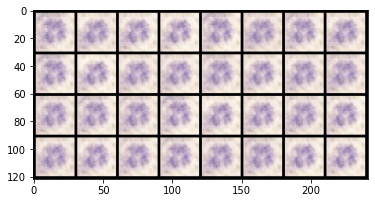

Epoch: [32] [   0/ 146] time: 129.1893, d_loss: 0.37131724, g_loss: 2.44461012
Epoch: [32] [   1/ 146] time: 129.2189, d_loss: 0.37280092, g_loss: 2.30482388
Epoch: [32] [   2/ 146] time: 129.2430, d_loss: 0.25912508, g_loss: 1.96334910
Epoch: [32] [   3/ 146] time: 129.2663, d_loss: 0.39523494, g_loss: 2.14176941
Epoch: [32] [   4/ 146] time: 129.2901, d_loss: 0.46916616, g_loss: 2.25514603
Epoch: [32] [   5/ 146] time: 129.3168, d_loss: 0.37508768, g_loss: 2.61718750
Epoch: [32] [   6/ 146] time: 129.3437, d_loss: 0.34373665, g_loss: 2.21549654
Epoch: [32] [   7/ 146] time: 129.3705, d_loss: 0.60989904, g_loss: 1.20396364
Epoch: [32] [   8/ 146] time: 129.3990, d_loss: 0.80639666, g_loss: 2.60233688
Epoch: [32] [   9/ 146] time: 129.4295, d_loss: 0.39644140, g_loss: 2.77004671
Epoch: [32] [  10/ 146] time: 129.4566, d_loss: 0.38884005, g_loss: 2.12383175
Epoch: [32] [  11/ 146] time: 129.4853, d_loss: 0.29107973, g_loss: 1.85468268
Epoch: [32] [  12/ 146] time: 129.5126, d_loss: 0.44

Epoch: [32] [ 104/ 146] time: 132.1580, d_loss: 0.29257548, g_loss: 2.44802189
Epoch: [32] [ 105/ 146] time: 132.1855, d_loss: 0.46856993, g_loss: 2.36619043
Epoch: [32] [ 106/ 146] time: 132.2144, d_loss: 0.22790152, g_loss: 2.38769317
Epoch: [32] [ 107/ 146] time: 132.2425, d_loss: 0.36105883, g_loss: 2.25179935
Epoch: [32] [ 108/ 146] time: 132.2708, d_loss: 0.21037051, g_loss: 2.26403308
Epoch: [32] [ 109/ 146] time: 132.2994, d_loss: 0.23652531, g_loss: 2.42673349
Epoch: [32] [ 110/ 146] time: 132.3269, d_loss: 0.18365663, g_loss: 2.63376522
Epoch: [32] [ 111/ 146] time: 132.3546, d_loss: 0.12951657, g_loss: 3.17132854
Epoch: [32] [ 112/ 146] time: 132.3845, d_loss: 0.12982060, g_loss: 3.27763820
Epoch: [32] [ 113/ 146] time: 132.4135, d_loss: 0.17708471, g_loss: 3.04467463
Epoch: [32] [ 114/ 146] time: 132.4419, d_loss: 0.14784500, g_loss: 2.80030394
Epoch: [32] [ 115/ 146] time: 132.4708, d_loss: 0.18352178, g_loss: 2.64875054
Epoch: [32] [ 116/ 146] time: 132.5009, d_loss: 0.36

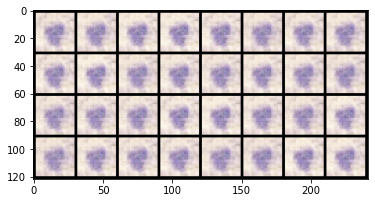

Epoch: [33] [   0/ 146] time: 133.5535, d_loss: 0.49848786, g_loss: 2.10202312
Epoch: [33] [   1/ 146] time: 133.5803, d_loss: 0.50300813, g_loss: 1.63391542
Epoch: [33] [   2/ 146] time: 133.6068, d_loss: 0.36541519, g_loss: 2.25905704
Epoch: [33] [   3/ 146] time: 133.6339, d_loss: 0.36893108, g_loss: 2.43254852
Epoch: [33] [   4/ 146] time: 133.6627, d_loss: 0.49785817, g_loss: 1.86314535
Epoch: [33] [   5/ 146] time: 133.6899, d_loss: 0.44134796, g_loss: 1.70615983
Epoch: [33] [   6/ 146] time: 133.7182, d_loss: 0.46988025, g_loss: 2.26945043
Epoch: [33] [   7/ 146] time: 133.7463, d_loss: 0.48103067, g_loss: 1.89015174
Epoch: [33] [   8/ 146] time: 133.7769, d_loss: 0.67276376, g_loss: 1.43381596
Epoch: [33] [   9/ 146] time: 133.8045, d_loss: 0.47952181, g_loss: 2.20813751
Epoch: [33] [  10/ 146] time: 133.8327, d_loss: 0.54062855, g_loss: 1.87597990
Epoch: [33] [  11/ 146] time: 133.8617, d_loss: 0.51081824, g_loss: 1.65731227
Epoch: [33] [  12/ 146] time: 133.8910, d_loss: 0.44

Epoch: [33] [ 109/ 146] time: 136.7023, d_loss: 0.61224186, g_loss: 1.60455477
Epoch: [33] [ 110/ 146] time: 136.7309, d_loss: 0.53283590, g_loss: 1.92831016
Epoch: [33] [ 111/ 146] time: 136.7607, d_loss: 0.52793568, g_loss: 2.25061750
Epoch: [33] [ 112/ 146] time: 136.7901, d_loss: 0.41933537, g_loss: 2.15154266
Epoch: [33] [ 113/ 146] time: 136.8191, d_loss: 0.44999468, g_loss: 1.79463327
Epoch: [33] [ 114/ 146] time: 136.8481, d_loss: 0.34521431, g_loss: 2.07010460
Epoch: [33] [ 115/ 146] time: 136.8773, d_loss: 0.47843540, g_loss: 2.08550978
Epoch: [33] [ 116/ 146] time: 136.9050, d_loss: 0.33626831, g_loss: 2.28178692
Epoch: [33] [ 117/ 146] time: 136.9355, d_loss: 0.50156665, g_loss: 1.74790907
Epoch: [33] [ 118/ 146] time: 136.9656, d_loss: 0.43690801, g_loss: 2.20578623
Epoch: [33] [ 119/ 146] time: 136.9957, d_loss: 0.56059933, g_loss: 2.04493260
Epoch: [33] [ 120/ 146] time: 137.0243, d_loss: 0.56995231, g_loss: 1.89931774
Epoch: [33] [ 121/ 146] time: 137.0532, d_loss: 0.54

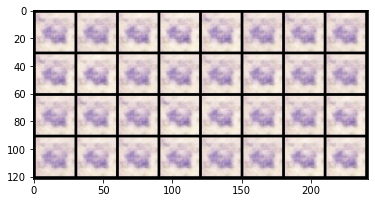

Epoch: [34] [   0/ 146] time: 137.9487, d_loss: 0.52190167, g_loss: 2.07026720
Epoch: [34] [   1/ 146] time: 137.9780, d_loss: 0.57739049, g_loss: 1.89137959
Epoch: [34] [   2/ 146] time: 138.0018, d_loss: 0.47744110, g_loss: 2.02144051
Epoch: [34] [   3/ 146] time: 138.0267, d_loss: 0.32695907, g_loss: 2.20626450
Epoch: [34] [   4/ 146] time: 138.0525, d_loss: 0.34858340, g_loss: 2.29126430
Epoch: [34] [   5/ 146] time: 138.0798, d_loss: 0.24292697, g_loss: 2.38527513
Epoch: [34] [   6/ 146] time: 138.1065, d_loss: 0.27525118, g_loss: 2.18604898
Epoch: [34] [   7/ 146] time: 138.1334, d_loss: 0.40693659, g_loss: 2.04372430
Epoch: [34] [   8/ 146] time: 138.1612, d_loss: 0.51953554, g_loss: 2.20290327
Epoch: [34] [   9/ 146] time: 138.1906, d_loss: 0.58422542, g_loss: 1.75348699
Epoch: [34] [  10/ 146] time: 138.2173, d_loss: 0.53322327, g_loss: 1.56840587
Epoch: [34] [  11/ 146] time: 138.2464, d_loss: 0.51929122, g_loss: 1.87804949
Epoch: [34] [  12/ 146] time: 138.2733, d_loss: 0.45

Epoch: [34] [ 109/ 146] time: 141.0984, d_loss: 0.34468883, g_loss: 1.98484373
Epoch: [34] [ 110/ 146] time: 141.1254, d_loss: 0.57759655, g_loss: 1.60915303
Epoch: [34] [ 111/ 146] time: 141.1530, d_loss: 0.43721235, g_loss: 2.28192568
Epoch: [34] [ 112/ 146] time: 141.1812, d_loss: 0.42756835, g_loss: 2.42042971
Epoch: [34] [ 113/ 146] time: 141.2113, d_loss: 0.43813965, g_loss: 1.83719444
Epoch: [34] [ 114/ 146] time: 141.2408, d_loss: 0.44422638, g_loss: 1.99536228
Epoch: [34] [ 115/ 146] time: 141.2703, d_loss: 0.58019054, g_loss: 2.02131414
Epoch: [34] [ 116/ 146] time: 141.2997, d_loss: 0.50196815, g_loss: 1.93847752
Epoch: [34] [ 117/ 146] time: 141.3294, d_loss: 0.48725271, g_loss: 1.73727226
Epoch: [34] [ 118/ 146] time: 141.3569, d_loss: 0.47466037, g_loss: 1.78264546
Epoch: [34] [ 119/ 146] time: 141.3859, d_loss: 0.39022154, g_loss: 2.52413511
Epoch: [34] [ 120/ 146] time: 141.4163, d_loss: 0.33332887, g_loss: 2.52337575
Epoch: [34] [ 121/ 146] time: 141.4457, d_loss: 0.39

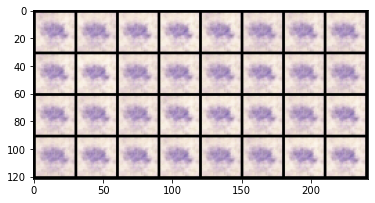

Epoch: [35] [   0/ 146] time: 142.3638, d_loss: 0.40740120, g_loss: 1.94251204
Epoch: [35] [   1/ 146] time: 142.3904, d_loss: 0.40843755, g_loss: 1.61341763
Epoch: [35] [   2/ 146] time: 142.4149, d_loss: 0.45497221, g_loss: 2.26542425
Epoch: [35] [   3/ 146] time: 142.4399, d_loss: 0.36658019, g_loss: 2.52738094
Epoch: [35] [   4/ 146] time: 142.4657, d_loss: 0.32907760, g_loss: 2.29061627
Epoch: [35] [   5/ 146] time: 142.4928, d_loss: 0.34548655, g_loss: 1.98670888
Epoch: [35] [   6/ 146] time: 142.5205, d_loss: 0.36856216, g_loss: 1.99074054
Epoch: [35] [   7/ 146] time: 142.5480, d_loss: 0.29724008, g_loss: 2.41689682
Epoch: [35] [   8/ 146] time: 142.5777, d_loss: 0.42041820, g_loss: 2.24834180
Epoch: [35] [   9/ 146] time: 142.6069, d_loss: 0.27176210, g_loss: 2.21815133
Epoch: [35] [  10/ 146] time: 142.6359, d_loss: 0.36517680, g_loss: 2.05034781
Epoch: [35] [  11/ 146] time: 142.6659, d_loss: 0.35219738, g_loss: 2.53578615
Epoch: [35] [  12/ 146] time: 142.6936, d_loss: 0.46

Epoch: [35] [ 111/ 146] time: 145.5482, d_loss: 0.46020937, g_loss: 2.37077045
Epoch: [35] [ 112/ 146] time: 145.5758, d_loss: 0.49834514, g_loss: 1.91749334
Epoch: [35] [ 113/ 146] time: 145.6045, d_loss: 0.44428253, g_loss: 2.11053801
Epoch: [35] [ 114/ 146] time: 145.6343, d_loss: 0.47846726, g_loss: 1.97250032
Epoch: [35] [ 115/ 146] time: 145.6634, d_loss: 0.38279590, g_loss: 2.20825434
Epoch: [35] [ 116/ 146] time: 145.6929, d_loss: 0.34173524, g_loss: 2.27032757
Epoch: [35] [ 117/ 146] time: 145.7221, d_loss: 0.44900548, g_loss: 2.00409865
Epoch: [35] [ 118/ 146] time: 145.7539, d_loss: 0.35829389, g_loss: 2.57310438
Epoch: [35] [ 119/ 146] time: 145.7838, d_loss: 0.46136785, g_loss: 2.22082090
Epoch: [35] [ 120/ 146] time: 145.8128, d_loss: 0.40052915, g_loss: 1.87477756
Epoch: [35] [ 121/ 146] time: 145.8423, d_loss: 0.37387225, g_loss: 2.17907715
Epoch: [35] [ 122/ 146] time: 145.8727, d_loss: 0.56687081, g_loss: 1.82549679
Epoch: [35] [ 123/ 146] time: 145.9024, d_loss: 0.34

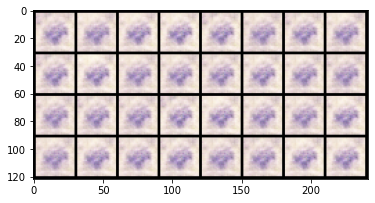

Epoch: [36] [   0/ 146] time: 146.7466, d_loss: 0.56508315, g_loss: 1.17669034
Epoch: [36] [   1/ 146] time: 146.7680, d_loss: 1.21887648, g_loss: 3.28835201
Epoch: [36] [   2/ 146] time: 146.7925, d_loss: 0.77607578, g_loss: 1.87921846
Epoch: [36] [   3/ 146] time: 146.8180, d_loss: 0.76096189, g_loss: 0.57179439
Epoch: [36] [   4/ 146] time: 146.8446, d_loss: 1.42638552, g_loss: 2.95592785
Epoch: [36] [   5/ 146] time: 146.8771, d_loss: 0.93183297, g_loss: 2.78052831
Epoch: [36] [   6/ 146] time: 146.9048, d_loss: 0.35700247, g_loss: 1.52165794
Epoch: [36] [   7/ 146] time: 146.9338, d_loss: 1.20499468, g_loss: 2.64694357
Epoch: [36] [   8/ 146] time: 146.9645, d_loss: 0.65359241, g_loss: 2.61998510
Epoch: [36] [   9/ 146] time: 146.9913, d_loss: 0.65020990, g_loss: 1.32489538
Epoch: [36] [  10/ 146] time: 147.0198, d_loss: 0.91479099, g_loss: 1.90425837
Epoch: [36] [  11/ 146] time: 147.0502, d_loss: 0.68473291, g_loss: 1.69717479
Epoch: [36] [  12/ 146] time: 147.0801, d_loss: 0.40

Epoch: [36] [ 108/ 146] time: 149.8646, d_loss: 0.32699722, g_loss: 2.53935051
Epoch: [36] [ 109/ 146] time: 149.8928, d_loss: 0.45914781, g_loss: 1.81347251
Epoch: [36] [ 110/ 146] time: 149.9204, d_loss: 0.52131772, g_loss: 2.36080360
Epoch: [36] [ 111/ 146] time: 149.9485, d_loss: 0.42403141, g_loss: 2.44724417
Epoch: [36] [ 112/ 146] time: 149.9766, d_loss: 0.33729768, g_loss: 2.07283330
Epoch: [36] [ 113/ 146] time: 150.0031, d_loss: 0.32663056, g_loss: 1.95503330
Epoch: [36] [ 114/ 146] time: 150.0300, d_loss: 0.48742610, g_loss: 1.41701293
Epoch: [36] [ 115/ 146] time: 150.0584, d_loss: 0.48528388, g_loss: 2.21520257
Epoch: [36] [ 116/ 146] time: 150.0862, d_loss: 0.36567429, g_loss: 2.70187712
Epoch: [36] [ 117/ 146] time: 150.1124, d_loss: 0.75183916, g_loss: 1.21997285
Epoch: [36] [ 118/ 146] time: 150.1417, d_loss: 0.64312923, g_loss: 1.85078967
Epoch: [36] [ 119/ 146] time: 150.1706, d_loss: 0.45886660, g_loss: 2.52941942
Epoch: [36] [ 120/ 146] time: 150.1988, d_loss: 0.35

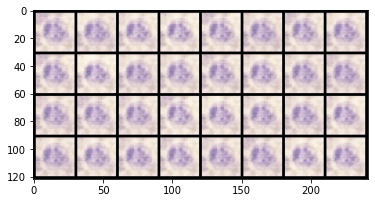

Epoch: [37] [   0/ 146] time: 151.1242, d_loss: 0.47327498, g_loss: 1.82464862
Epoch: [37] [   1/ 146] time: 151.1528, d_loss: 0.44102859, g_loss: 2.55260396
Epoch: [37] [   2/ 146] time: 151.1762, d_loss: 0.44356173, g_loss: 2.37724781
Epoch: [37] [   3/ 146] time: 151.1999, d_loss: 0.42027292, g_loss: 1.80821860
Epoch: [37] [   4/ 146] time: 151.2239, d_loss: 0.36453402, g_loss: 1.95619798
Epoch: [37] [   5/ 146] time: 151.2504, d_loss: 0.38355845, g_loss: 2.75002694
Epoch: [37] [   6/ 146] time: 151.2778, d_loss: 0.48309919, g_loss: 2.41684341
Epoch: [37] [   7/ 146] time: 151.3058, d_loss: 0.54785216, g_loss: 1.52126217
Epoch: [37] [   8/ 146] time: 151.3347, d_loss: 0.45191720, g_loss: 1.77484441
Epoch: [37] [   9/ 146] time: 151.3656, d_loss: 0.37045491, g_loss: 2.35675955
Epoch: [37] [  10/ 146] time: 151.3939, d_loss: 0.26648539, g_loss: 2.64357758
Epoch: [37] [  11/ 146] time: 151.4242, d_loss: 0.54582787, g_loss: 1.89617670
Epoch: [37] [  12/ 146] time: 151.4521, d_loss: 0.42

Epoch: [37] [ 108/ 146] time: 154.2505, d_loss: 0.33039671, g_loss: 2.07901883
Epoch: [37] [ 109/ 146] time: 154.2818, d_loss: 0.32005721, g_loss: 2.28837585
Epoch: [37] [ 110/ 146] time: 154.3108, d_loss: 0.31799400, g_loss: 2.42107010
Epoch: [37] [ 111/ 146] time: 154.3392, d_loss: 0.36220267, g_loss: 2.25546479
Epoch: [37] [ 112/ 146] time: 154.3676, d_loss: 0.37246352, g_loss: 1.92055559
Epoch: [37] [ 113/ 146] time: 154.3963, d_loss: 0.28733504, g_loss: 2.13531876
Epoch: [37] [ 114/ 146] time: 154.4234, d_loss: 0.31245762, g_loss: 2.32425284
Epoch: [37] [ 115/ 146] time: 154.4515, d_loss: 0.26533428, g_loss: 2.59256196
Epoch: [37] [ 116/ 146] time: 154.4832, d_loss: 0.27519161, g_loss: 2.34454179
Epoch: [37] [ 117/ 146] time: 154.5103, d_loss: 0.33636951, g_loss: 2.13150716
Epoch: [37] [ 118/ 146] time: 154.5375, d_loss: 0.33924899, g_loss: 2.32019424
Epoch: [37] [ 119/ 146] time: 154.5650, d_loss: 0.43100888, g_loss: 2.12235880
Epoch: [37] [ 120/ 146] time: 154.5947, d_loss: 0.46

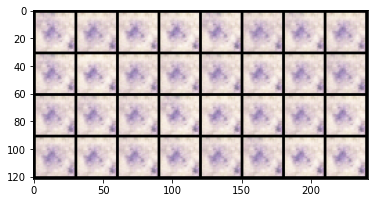

Epoch: [38] [   0/ 146] time: 155.5205, d_loss: 0.39693367, g_loss: 2.00677156
Epoch: [38] [   1/ 146] time: 155.5488, d_loss: 0.48813096, g_loss: 1.82052207
Epoch: [38] [   2/ 146] time: 155.6101, d_loss: 0.36776507, g_loss: 2.14175034
Epoch: [38] [   3/ 146] time: 155.6647, d_loss: 0.35209927, g_loss: 2.64328790
Epoch: [38] [   4/ 146] time: 155.7195, d_loss: 0.29417145, g_loss: 2.67036939
Epoch: [38] [   5/ 146] time: 155.7764, d_loss: 0.42373601, g_loss: 1.98600411
Epoch: [38] [   6/ 146] time: 155.8297, d_loss: 0.35561931, g_loss: 2.03272700
Epoch: [38] [   7/ 146] time: 155.8841, d_loss: 0.42106262, g_loss: 2.08871174
Epoch: [38] [   8/ 146] time: 155.9386, d_loss: 0.33809346, g_loss: 2.35538507
Epoch: [38] [   9/ 146] time: 155.9951, d_loss: 0.45098972, g_loss: 1.99476540
Epoch: [38] [  10/ 146] time: 156.0488, d_loss: 0.29981548, g_loss: 2.33914280
Epoch: [38] [  11/ 146] time: 156.1034, d_loss: 0.32488313, g_loss: 2.44791198
Epoch: [38] [  12/ 146] time: 156.1576, d_loss: 0.28

Epoch: [38] [ 105/ 146] time: 161.2539, d_loss: 0.21408668, g_loss: 2.85396719
Epoch: [38] [ 106/ 146] time: 161.3094, d_loss: 0.29460886, g_loss: 2.52450681
Epoch: [38] [ 107/ 146] time: 161.3633, d_loss: 0.19311321, g_loss: 2.72974920
Epoch: [38] [ 108/ 146] time: 161.4177, d_loss: 0.22788548, g_loss: 2.47659397
Epoch: [38] [ 109/ 146] time: 161.4723, d_loss: 0.27729782, g_loss: 2.21025848
Epoch: [38] [ 110/ 146] time: 161.5290, d_loss: 0.25391537, g_loss: 2.05705380
Epoch: [38] [ 111/ 146] time: 161.5829, d_loss: 0.49930343, g_loss: 2.06253719
Epoch: [38] [ 112/ 146] time: 161.8777, d_loss: 0.31577080, g_loss: 2.43629408
Epoch: [38] [ 113/ 146] time: 161.9126, d_loss: 0.41923761, g_loss: 1.78439975
Epoch: [38] [ 114/ 146] time: 161.9427, d_loss: 0.51503348, g_loss: 1.70648205
Epoch: [38] [ 115/ 146] time: 161.9834, d_loss: 0.44019467, g_loss: 2.44710827
Epoch: [38] [ 116/ 146] time: 162.0191, d_loss: 0.35886994, g_loss: 2.72995019
Epoch: [38] [ 117/ 146] time: 162.0573, d_loss: 0.20

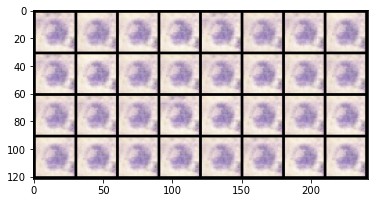

Epoch: [39] [   0/ 146] time: 163.5692, d_loss: 0.27020100, g_loss: 2.40903163
Epoch: [39] [   1/ 146] time: 163.5999, d_loss: 0.48909697, g_loss: 1.79040015
Epoch: [39] [   2/ 146] time: 163.6274, d_loss: 0.61668211, g_loss: 1.20718026
Epoch: [39] [   3/ 146] time: 163.6552, d_loss: 0.67011499, g_loss: 2.39008069
Epoch: [39] [   4/ 146] time: 163.6821, d_loss: 0.49497885, g_loss: 2.46027327
Epoch: [39] [   5/ 146] time: 163.7106, d_loss: 0.40474343, g_loss: 2.04971337
Epoch: [39] [   6/ 146] time: 163.7391, d_loss: 0.31039512, g_loss: 2.11087894
Epoch: [39] [   7/ 146] time: 163.7673, d_loss: 0.37185460, g_loss: 2.26578856
Epoch: [39] [   8/ 146] time: 163.7980, d_loss: 0.72132361, g_loss: 1.56930065
Epoch: [39] [   9/ 146] time: 163.8259, d_loss: 0.54493785, g_loss: 1.78218865
Epoch: [39] [  10/ 146] time: 163.8543, d_loss: 0.41093439, g_loss: 2.27654934
Epoch: [39] [  11/ 146] time: 163.8834, d_loss: 0.55629224, g_loss: 1.59642506
Epoch: [39] [  12/ 146] time: 163.9110, d_loss: 0.53

Epoch: [39] [ 104/ 146] time: 166.5382, d_loss: 0.51884329, g_loss: 2.29630709
Epoch: [39] [ 105/ 146] time: 166.5649, d_loss: 0.53293586, g_loss: 2.17845917
Epoch: [39] [ 106/ 146] time: 166.5927, d_loss: 0.51586694, g_loss: 1.60373044
Epoch: [39] [ 107/ 146] time: 166.6206, d_loss: 0.46470746, g_loss: 2.34908247
Epoch: [39] [ 108/ 146] time: 166.6496, d_loss: 0.40172982, g_loss: 2.44258785
Epoch: [39] [ 109/ 146] time: 166.6783, d_loss: 0.57668447, g_loss: 1.43288970
Epoch: [39] [ 110/ 146] time: 166.7071, d_loss: 0.62189299, g_loss: 2.39917469
Epoch: [39] [ 111/ 146] time: 166.7356, d_loss: 0.36433059, g_loss: 2.68214107
Epoch: [39] [ 112/ 146] time: 166.7646, d_loss: 0.67249173, g_loss: 1.61890733
Epoch: [39] [ 113/ 146] time: 166.7919, d_loss: 0.53096741, g_loss: 2.12372017
Epoch: [39] [ 114/ 146] time: 166.8223, d_loss: 0.39280769, g_loss: 2.66242433
Epoch: [39] [ 115/ 146] time: 166.8507, d_loss: 0.63186032, g_loss: 1.71289682
Epoch: [39] [ 116/ 146] time: 166.8784, d_loss: 0.43

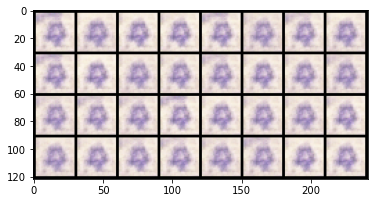

Epoch: [40] [   0/ 146] time: 167.9168, d_loss: 0.41036180, g_loss: 2.09431577
Epoch: [40] [   1/ 146] time: 167.9443, d_loss: 0.32268855, g_loss: 2.83116198
Epoch: [40] [   2/ 146] time: 167.9716, d_loss: 0.55716759, g_loss: 1.80358469
Epoch: [40] [   3/ 146] time: 167.9988, d_loss: 0.40332547, g_loss: 1.97480893
Epoch: [40] [   4/ 146] time: 168.0261, d_loss: 0.35608864, g_loss: 2.50831199
Epoch: [40] [   5/ 146] time: 168.0551, d_loss: 0.32050133, g_loss: 2.54690361
Epoch: [40] [   6/ 146] time: 168.0837, d_loss: 0.34584647, g_loss: 2.05857277
Epoch: [40] [   7/ 146] time: 168.1121, d_loss: 0.42010164, g_loss: 2.18863678
Epoch: [40] [   8/ 146] time: 168.1440, d_loss: 0.49271226, g_loss: 2.33470559
Epoch: [40] [   9/ 146] time: 168.1690, d_loss: 0.37105131, g_loss: 2.23800421
Epoch: [40] [  10/ 146] time: 168.1961, d_loss: 0.38337180, g_loss: 2.08227396
Epoch: [40] [  11/ 146] time: 168.2252, d_loss: 0.33699858, g_loss: 2.24156952
Epoch: [40] [  12/ 146] time: 168.2519, d_loss: 0.47

Epoch: [40] [ 108/ 146] time: 171.0314, d_loss: 0.26040429, g_loss: 2.60648489
Epoch: [40] [ 109/ 146] time: 171.0651, d_loss: 0.45564198, g_loss: 1.84012222
Epoch: [40] [ 110/ 146] time: 171.0927, d_loss: 0.40226924, g_loss: 1.94645834
Epoch: [40] [ 111/ 146] time: 171.1214, d_loss: 0.44707188, g_loss: 2.39685011
Epoch: [40] [ 112/ 146] time: 171.1521, d_loss: 0.41047645, g_loss: 2.24094915
Epoch: [40] [ 113/ 146] time: 171.1818, d_loss: 0.32430890, g_loss: 2.09834695
Epoch: [40] [ 114/ 146] time: 171.2114, d_loss: 0.37600207, g_loss: 1.89445567
Epoch: [40] [ 115/ 146] time: 171.2415, d_loss: 0.45000476, g_loss: 2.46080565
Epoch: [40] [ 116/ 146] time: 171.2745, d_loss: 0.40098822, g_loss: 2.24608612
Epoch: [40] [ 117/ 146] time: 171.3031, d_loss: 0.35088009, g_loss: 2.21424174
Epoch: [40] [ 118/ 146] time: 171.3325, d_loss: 0.31791991, g_loss: 2.48809314
Epoch: [40] [ 119/ 146] time: 171.3618, d_loss: 0.41135567, g_loss: 1.92508662
Epoch: [40] [ 120/ 146] time: 171.3920, d_loss: 0.31

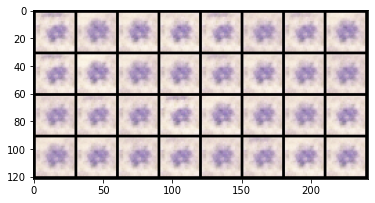

Epoch: [41] [   0/ 146] time: 172.3291, d_loss: 0.41628227, g_loss: 1.94166267
Epoch: [41] [   1/ 146] time: 172.3563, d_loss: 0.54619360, g_loss: 1.75215578
Epoch: [41] [   2/ 146] time: 172.3844, d_loss: 0.43596315, g_loss: 2.74699497
Epoch: [41] [   3/ 146] time: 172.4129, d_loss: 0.60098219, g_loss: 1.99489093
Epoch: [41] [   4/ 146] time: 172.4407, d_loss: 0.26266560, g_loss: 2.26203084
Epoch: [41] [   5/ 146] time: 172.4674, d_loss: 0.44353512, g_loss: 2.18393302
Epoch: [41] [   6/ 146] time: 172.4948, d_loss: 0.38321635, g_loss: 2.16448212
Epoch: [41] [   7/ 146] time: 172.5231, d_loss: 0.38743410, g_loss: 2.35427332
Epoch: [41] [   8/ 146] time: 172.5514, d_loss: 0.54112822, g_loss: 1.77474737
Epoch: [41] [   9/ 146] time: 172.5780, d_loss: 0.60264379, g_loss: 1.58307779
Epoch: [41] [  10/ 146] time: 172.6065, d_loss: 0.57025468, g_loss: 2.08518386
Epoch: [41] [  11/ 146] time: 172.6354, d_loss: 0.37704578, g_loss: 2.46018147
Epoch: [41] [  12/ 146] time: 172.6656, d_loss: 0.37

Epoch: [41] [ 110/ 146] time: 175.5079, d_loss: 0.47801366, g_loss: 2.14326715
Epoch: [41] [ 111/ 146] time: 175.5374, d_loss: 0.51231229, g_loss: 1.90934289
Epoch: [41] [ 112/ 146] time: 175.5647, d_loss: 0.43459916, g_loss: 2.24791288
Epoch: [41] [ 113/ 146] time: 175.5926, d_loss: 0.49902856, g_loss: 1.98211300
Epoch: [41] [ 114/ 146] time: 175.6215, d_loss: 0.61210740, g_loss: 2.12012672
Epoch: [41] [ 115/ 146] time: 175.6522, d_loss: 0.65099895, g_loss: 1.65620589
Epoch: [41] [ 116/ 146] time: 175.6812, d_loss: 0.54837424, g_loss: 2.67616272
Epoch: [41] [ 117/ 146] time: 175.7102, d_loss: 0.53358442, g_loss: 2.09778404
Epoch: [41] [ 118/ 146] time: 175.7418, d_loss: 0.57051080, g_loss: 1.21168280
Epoch: [41] [ 119/ 146] time: 175.7709, d_loss: 0.76502943, g_loss: 2.38004208
Epoch: [41] [ 120/ 146] time: 175.7988, d_loss: 0.49748561, g_loss: 2.63244390
Epoch: [41] [ 121/ 146] time: 175.8272, d_loss: 0.36405665, g_loss: 2.25402451
Epoch: [41] [ 122/ 146] time: 175.8577, d_loss: 0.27

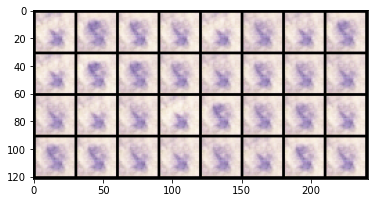

Epoch: [42] [   0/ 146] time: 176.7333, d_loss: 0.43197173, g_loss: 1.98243153
Epoch: [42] [   1/ 146] time: 176.7621, d_loss: 0.31064135, g_loss: 2.32009888
Epoch: [42] [   2/ 146] time: 176.7853, d_loss: 0.28119785, g_loss: 2.27079630
Epoch: [42] [   3/ 146] time: 176.8091, d_loss: 0.28746924, g_loss: 2.26199722
Epoch: [42] [   4/ 146] time: 176.8398, d_loss: 0.28870857, g_loss: 2.27700830
Epoch: [42] [   5/ 146] time: 176.8675, d_loss: 0.35059023, g_loss: 2.40744448
Epoch: [42] [   6/ 146] time: 176.8956, d_loss: 0.29713190, g_loss: 2.53945565
Epoch: [42] [   7/ 146] time: 176.9262, d_loss: 0.37188840, g_loss: 1.89400911
Epoch: [42] [   8/ 146] time: 176.9554, d_loss: 0.47479713, g_loss: 2.04137135
Epoch: [42] [   9/ 146] time: 176.9832, d_loss: 0.30386764, g_loss: 2.97612906
Epoch: [42] [  10/ 146] time: 177.0115, d_loss: 0.48146036, g_loss: 1.86160553
Epoch: [42] [  11/ 146] time: 177.0405, d_loss: 0.29821467, g_loss: 2.07972932
Epoch: [42] [  12/ 146] time: 177.0686, d_loss: 0.36

Epoch: [42] [ 110/ 146] time: 179.8898, d_loss: 0.32449383, g_loss: 2.28250551
Epoch: [42] [ 111/ 146] time: 179.9209, d_loss: 0.35812134, g_loss: 1.85690808
Epoch: [42] [ 112/ 146] time: 179.9491, d_loss: 0.34784830, g_loss: 2.56624627
Epoch: [42] [ 113/ 146] time: 179.9785, d_loss: 0.23805235, g_loss: 2.78302765
Epoch: [42] [ 114/ 146] time: 180.0056, d_loss: 0.20320556, g_loss: 2.63467312
Epoch: [42] [ 115/ 146] time: 180.0343, d_loss: 0.32137805, g_loss: 2.03824258
Epoch: [42] [ 116/ 146] time: 180.0647, d_loss: 0.36752594, g_loss: 2.21617866
Epoch: [42] [ 117/ 146] time: 180.0963, d_loss: 0.38941675, g_loss: 1.96404886
Epoch: [42] [ 118/ 146] time: 180.1274, d_loss: 0.42010957, g_loss: 1.81619513
Epoch: [42] [ 119/ 146] time: 180.1565, d_loss: 0.41418260, g_loss: 2.00281668
Epoch: [42] [ 120/ 146] time: 180.1871, d_loss: 0.31846529, g_loss: 2.43924522
Epoch: [42] [ 121/ 146] time: 180.2166, d_loss: 0.37955633, g_loss: 2.10521054
Epoch: [42] [ 122/ 146] time: 180.2469, d_loss: 0.55

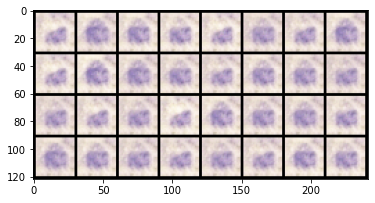

Epoch: [43] [   0/ 146] time: 181.1448, d_loss: 0.37935609, g_loss: 2.37147355
Epoch: [43] [   1/ 146] time: 181.1730, d_loss: 0.40055186, g_loss: 1.85842609
Epoch: [43] [   2/ 146] time: 181.2207, d_loss: 0.42026165, g_loss: 1.59244275
Epoch: [43] [   3/ 146] time: 181.2532, d_loss: 0.28757513, g_loss: 2.39926863
Epoch: [43] [   4/ 146] time: 181.2984, d_loss: 0.42127353, g_loss: 2.03558946
Epoch: [43] [   5/ 146] time: 181.3362, d_loss: 0.37437209, g_loss: 2.17014408
Epoch: [43] [   6/ 146] time: 181.3771, d_loss: 0.26786277, g_loss: 2.14644051
Epoch: [43] [   7/ 146] time: 181.4314, d_loss: 0.44259399, g_loss: 2.25643682
Epoch: [43] [   8/ 146] time: 181.4874, d_loss: 0.47668719, g_loss: 2.21129370
Epoch: [43] [   9/ 146] time: 181.5385, d_loss: 0.45555010, g_loss: 2.23238659
Epoch: [43] [  10/ 146] time: 181.5941, d_loss: 0.46043313, g_loss: 1.55273890
Epoch: [43] [  11/ 146] time: 181.6487, d_loss: 0.62684005, g_loss: 2.65539074
Epoch: [43] [  12/ 146] time: 181.7038, d_loss: 0.78

Epoch: [43] [ 106/ 146] time: 185.2337, d_loss: 0.29876310, g_loss: 2.30426097
Epoch: [43] [ 107/ 146] time: 185.2646, d_loss: 0.20214787, g_loss: 2.64667273
Epoch: [43] [ 108/ 146] time: 185.2942, d_loss: 0.27986947, g_loss: 2.22043467
Epoch: [43] [ 109/ 146] time: 185.3238, d_loss: 0.31752908, g_loss: 1.94004941
Epoch: [43] [ 110/ 146] time: 185.3552, d_loss: 0.38228944, g_loss: 2.59561062
Epoch: [43] [ 111/ 146] time: 185.3832, d_loss: 0.25187549, g_loss: 2.74086261
Epoch: [43] [ 112/ 146] time: 185.4127, d_loss: 0.31962141, g_loss: 2.39010429
Epoch: [43] [ 113/ 146] time: 185.4428, d_loss: 0.18347779, g_loss: 2.76742911
Epoch: [43] [ 114/ 146] time: 185.4706, d_loss: 0.17295888, g_loss: 2.71851158
Epoch: [43] [ 115/ 146] time: 185.4982, d_loss: 0.31157443, g_loss: 2.27624083
Epoch: [43] [ 116/ 146] time: 185.5260, d_loss: 0.36177284, g_loss: 2.70353770
Epoch: [43] [ 117/ 146] time: 185.5555, d_loss: 0.42700619, g_loss: 1.98351908
Epoch: [43] [ 118/ 146] time: 185.5842, d_loss: 0.32

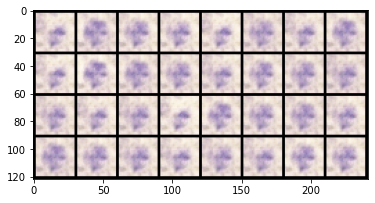

Epoch: [44] [   0/ 146] time: 186.5737, d_loss: 0.55643481, g_loss: 2.54749370
Epoch: [44] [   1/ 146] time: 186.6000, d_loss: 0.41676682, g_loss: 2.35320854
Epoch: [44] [   2/ 146] time: 186.6253, d_loss: 0.45119768, g_loss: 1.60485244
Epoch: [44] [   3/ 146] time: 186.6518, d_loss: 0.40611121, g_loss: 1.94911075
Epoch: [44] [   4/ 146] time: 186.6800, d_loss: 0.35282043, g_loss: 2.24426174
Epoch: [44] [   5/ 146] time: 186.7098, d_loss: 0.58060127, g_loss: 1.57530153
Epoch: [44] [   6/ 146] time: 186.7357, d_loss: 0.49923402, g_loss: 2.41226959
Epoch: [44] [   7/ 146] time: 186.7634, d_loss: 0.26579994, g_loss: 2.60929465
Epoch: [44] [   8/ 146] time: 186.7913, d_loss: 0.30808043, g_loss: 2.45774126
Epoch: [44] [   9/ 146] time: 186.8180, d_loss: 0.15468073, g_loss: 2.73477268
Epoch: [44] [  10/ 146] time: 186.8467, d_loss: 0.20740926, g_loss: 2.51951385
Epoch: [44] [  11/ 146] time: 186.8743, d_loss: 0.23527704, g_loss: 2.15672398
Epoch: [44] [  12/ 146] time: 186.9009, d_loss: 0.29

Epoch: [44] [ 104/ 146] time: 189.5653, d_loss: 0.58097148, g_loss: 1.63901687
Epoch: [44] [ 105/ 146] time: 189.5949, d_loss: 0.42138159, g_loss: 1.66878843
Epoch: [44] [ 106/ 146] time: 189.6246, d_loss: 0.51683486, g_loss: 2.20996332
Epoch: [44] [ 107/ 146] time: 189.6543, d_loss: 0.59313768, g_loss: 1.66488814
Epoch: [44] [ 108/ 146] time: 189.6842, d_loss: 0.43559152, g_loss: 1.95108831
Epoch: [44] [ 109/ 146] time: 189.7121, d_loss: 0.48185202, g_loss: 1.49803150
Epoch: [44] [ 110/ 146] time: 189.7409, d_loss: 0.46912023, g_loss: 1.57632685
Epoch: [44] [ 111/ 146] time: 189.7708, d_loss: 0.40216306, g_loss: 2.23930788
Epoch: [44] [ 112/ 146] time: 189.8031, d_loss: 0.99288130, g_loss: 0.88102782
Epoch: [44] [ 113/ 146] time: 189.8310, d_loss: 0.77749908, g_loss: 1.80497980
Epoch: [44] [ 114/ 146] time: 189.8601, d_loss: 0.41810989, g_loss: 2.65911102
Epoch: [44] [ 115/ 146] time: 189.8877, d_loss: 0.59031224, g_loss: 1.79847097
Epoch: [44] [ 116/ 146] time: 189.9156, d_loss: 0.43

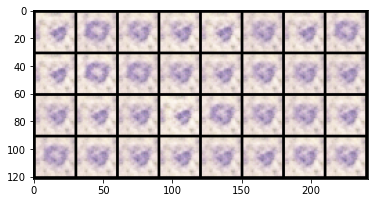

Epoch: [45] [   0/ 146] time: 190.9603, d_loss: 0.36312348, g_loss: 2.65750098
Epoch: [45] [   1/ 146] time: 190.9889, d_loss: 0.34702024, g_loss: 2.10346937
Epoch: [45] [   2/ 146] time: 191.0139, d_loss: 0.44849074, g_loss: 1.72303438
Epoch: [45] [   3/ 146] time: 191.0393, d_loss: 0.48210043, g_loss: 2.06225777
Epoch: [45] [   4/ 146] time: 191.0652, d_loss: 0.42232871, g_loss: 2.29941273
Epoch: [45] [   5/ 146] time: 191.0948, d_loss: 0.38134027, g_loss: 2.22894430
Epoch: [45] [   6/ 146] time: 191.1256, d_loss: 0.46388960, g_loss: 1.88040006
Epoch: [45] [   7/ 146] time: 191.1543, d_loss: 0.39013118, g_loss: 1.73178530
Epoch: [45] [   8/ 146] time: 191.1850, d_loss: 0.51563573, g_loss: 1.93832326
Epoch: [45] [   9/ 146] time: 191.2129, d_loss: 0.39271557, g_loss: 2.44585872
Epoch: [45] [  10/ 146] time: 191.2416, d_loss: 0.47149205, g_loss: 2.02860737
Epoch: [45] [  11/ 146] time: 191.2694, d_loss: 0.38296944, g_loss: 2.03729820
Epoch: [45] [  12/ 146] time: 191.2988, d_loss: 0.45

Epoch: [45] [ 109/ 146] time: 194.1181, d_loss: 0.40736413, g_loss: 2.46300149
Epoch: [45] [ 110/ 146] time: 194.1456, d_loss: 0.60766929, g_loss: 1.39689577
Epoch: [45] [ 111/ 146] time: 194.1732, d_loss: 0.62390244, g_loss: 2.39877176
Epoch: [45] [ 112/ 146] time: 194.2008, d_loss: 0.45015562, g_loss: 2.25785518
Epoch: [45] [ 113/ 146] time: 194.2308, d_loss: 0.53297603, g_loss: 1.48858905
Epoch: [45] [ 114/ 146] time: 194.2603, d_loss: 0.64053708, g_loss: 1.53502321
Epoch: [45] [ 115/ 146] time: 194.2897, d_loss: 0.60219371, g_loss: 2.53398895
Epoch: [45] [ 116/ 146] time: 194.3197, d_loss: 0.62398392, g_loss: 1.78261268
Epoch: [45] [ 117/ 146] time: 194.3499, d_loss: 0.41419262, g_loss: 1.54452312
Epoch: [45] [ 118/ 146] time: 194.3777, d_loss: 0.51254427, g_loss: 1.87738192
Epoch: [45] [ 119/ 146] time: 194.4069, d_loss: 0.53826320, g_loss: 1.78471303
Epoch: [45] [ 120/ 146] time: 194.4378, d_loss: 0.57765555, g_loss: 1.45755136
Epoch: [45] [ 121/ 146] time: 194.4656, d_loss: 0.73

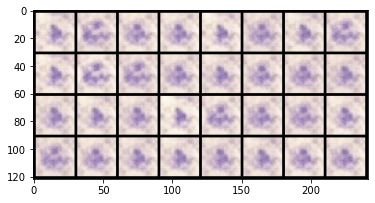

Epoch: [46] [   0/ 146] time: 195.3842, d_loss: 0.41451439, g_loss: 2.03053808
Epoch: [46] [   1/ 146] time: 195.4114, d_loss: 0.20571277, g_loss: 2.11196327
Epoch: [46] [   2/ 146] time: 195.4355, d_loss: 0.39164487, g_loss: 2.19101238
Epoch: [46] [   3/ 146] time: 195.4594, d_loss: 0.39409348, g_loss: 2.43838358
Epoch: [46] [   4/ 146] time: 195.4831, d_loss: 0.36663687, g_loss: 2.37730598
Epoch: [46] [   5/ 146] time: 195.5111, d_loss: 0.29760420, g_loss: 2.12317324
Epoch: [46] [   6/ 146] time: 195.5395, d_loss: 0.26135188, g_loss: 2.27467203
Epoch: [46] [   7/ 146] time: 195.5669, d_loss: 0.26734179, g_loss: 2.55095577
Epoch: [46] [   8/ 146] time: 195.5992, d_loss: 0.24960755, g_loss: 2.70121193
Epoch: [46] [   9/ 146] time: 195.6286, d_loss: 0.38267407, g_loss: 1.99327576
Epoch: [46] [  10/ 146] time: 195.6585, d_loss: 0.24178305, g_loss: 2.34580469
Epoch: [46] [  11/ 146] time: 195.6892, d_loss: 0.24589744, g_loss: 2.83361959
Epoch: [46] [  12/ 146] time: 195.7201, d_loss: 0.40

Epoch: [46] [ 108/ 146] time: 198.5195, d_loss: 0.22010803, g_loss: 2.53327322
Epoch: [46] [ 109/ 146] time: 198.5504, d_loss: 0.26919138, g_loss: 2.29319000
Epoch: [46] [ 110/ 146] time: 198.5789, d_loss: 0.30070239, g_loss: 2.32869864
Epoch: [46] [ 111/ 146] time: 198.6053, d_loss: 0.28006685, g_loss: 2.58049846
Epoch: [46] [ 112/ 146] time: 198.6329, d_loss: 0.59561324, g_loss: 1.42412496
Epoch: [46] [ 113/ 146] time: 198.6615, d_loss: 0.58426404, g_loss: 2.49564743
Epoch: [46] [ 114/ 146] time: 198.6909, d_loss: 0.76172751, g_loss: 1.60724163
Epoch: [46] [ 115/ 146] time: 198.7201, d_loss: 0.39997965, g_loss: 2.05954742
Epoch: [46] [ 116/ 146] time: 198.7515, d_loss: 0.50123155, g_loss: 1.73108470
Epoch: [46] [ 117/ 146] time: 198.7798, d_loss: 0.43820810, g_loss: 1.70034361
Epoch: [46] [ 118/ 146] time: 198.8063, d_loss: 0.59259450, g_loss: 1.60168242
Epoch: [46] [ 119/ 146] time: 198.8339, d_loss: 0.42964453, g_loss: 2.44875360
Epoch: [46] [ 120/ 146] time: 198.8621, d_loss: 0.62

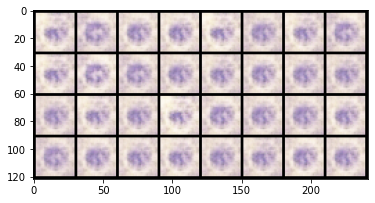

Epoch: [47] [   0/ 146] time: 199.8057, d_loss: 0.42093945, g_loss: 2.19930935
Epoch: [47] [   1/ 146] time: 199.8326, d_loss: 0.39014697, g_loss: 2.01230335
Epoch: [47] [   2/ 146] time: 199.8571, d_loss: 0.38659149, g_loss: 2.36156011
Epoch: [47] [   3/ 146] time: 199.8810, d_loss: 0.43672472, g_loss: 2.15143633
Epoch: [47] [   4/ 146] time: 199.9051, d_loss: 0.47524649, g_loss: 2.19227457
Epoch: [47] [   5/ 146] time: 199.9324, d_loss: 0.55614269, g_loss: 1.58222890
Epoch: [47] [   6/ 146] time: 199.9597, d_loss: 0.45350429, g_loss: 2.26333070
Epoch: [47] [   7/ 146] time: 199.9873, d_loss: 0.46325675, g_loss: 2.25046921
Epoch: [47] [   8/ 146] time: 200.0166, d_loss: 0.42508787, g_loss: 1.64185071
Epoch: [47] [   9/ 146] time: 200.0474, d_loss: 0.57039285, g_loss: 2.24907398
Epoch: [47] [  10/ 146] time: 200.0751, d_loss: 0.44021076, g_loss: 2.28763556
Epoch: [47] [  11/ 146] time: 200.1040, d_loss: 0.49642211, g_loss: 1.76864612
Epoch: [47] [  12/ 146] time: 200.1313, d_loss: 0.48

Epoch: [47] [ 108/ 146] time: 202.9327, d_loss: 0.30903405, g_loss: 2.26112366
Epoch: [47] [ 109/ 146] time: 202.9643, d_loss: 0.27726430, g_loss: 2.58982348
Epoch: [47] [ 110/ 146] time: 202.9941, d_loss: 0.43723533, g_loss: 2.23444128
Epoch: [47] [ 111/ 146] time: 203.0227, d_loss: 0.45635593, g_loss: 2.13134718
Epoch: [47] [ 112/ 146] time: 203.0519, d_loss: 0.40088332, g_loss: 1.69742966
Epoch: [47] [ 113/ 146] time: 203.0824, d_loss: 0.46120280, g_loss: 2.20518279
Epoch: [47] [ 114/ 146] time: 203.1120, d_loss: 0.46902788, g_loss: 2.44987297
Epoch: [47] [ 115/ 146] time: 203.1412, d_loss: 0.51707929, g_loss: 2.10226917
Epoch: [47] [ 116/ 146] time: 203.1725, d_loss: 0.34073213, g_loss: 1.79928684
Epoch: [47] [ 117/ 146] time: 203.2014, d_loss: 0.51356632, g_loss: 2.05181789
Epoch: [47] [ 118/ 146] time: 203.2279, d_loss: 0.58678520, g_loss: 1.53136742
Epoch: [47] [ 119/ 146] time: 203.2556, d_loss: 0.38316393, g_loss: 2.07345629
Epoch: [47] [ 120/ 146] time: 203.2842, d_loss: 0.42

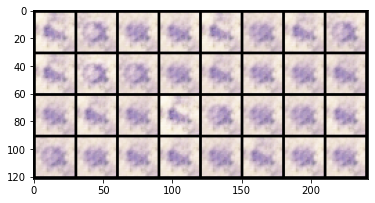

Epoch: [48] [   0/ 146] time: 204.2157, d_loss: 0.61700851, g_loss: 2.19078231
Epoch: [48] [   1/ 146] time: 204.2424, d_loss: 0.54491192, g_loss: 1.16518986
Epoch: [48] [   2/ 146] time: 204.2688, d_loss: 0.79935765, g_loss: 1.58940816
Epoch: [48] [   3/ 146] time: 204.2954, d_loss: 0.59028625, g_loss: 1.95012474
Epoch: [48] [   4/ 146] time: 204.3228, d_loss: 0.67466635, g_loss: 1.51063609
Epoch: [48] [   5/ 146] time: 204.3492, d_loss: 0.60781884, g_loss: 2.05115318
Epoch: [48] [   6/ 146] time: 204.3761, d_loss: 0.71799374, g_loss: 2.01220083
Epoch: [48] [   7/ 146] time: 204.4045, d_loss: 0.56878245, g_loss: 1.44067264
Epoch: [48] [   8/ 146] time: 204.4326, d_loss: 0.42637074, g_loss: 2.01730657
Epoch: [48] [   9/ 146] time: 204.4600, d_loss: 0.49524128, g_loss: 1.45466113
Epoch: [48] [  10/ 146] time: 204.4892, d_loss: 0.76597548, g_loss: 1.63750172
Epoch: [48] [  11/ 146] time: 204.5187, d_loss: 0.38758504, g_loss: 1.84375215
Epoch: [48] [  12/ 146] time: 204.5480, d_loss: 0.41

Epoch: [48] [ 108/ 146] time: 207.3440, d_loss: 0.53254235, g_loss: 1.67990434
Epoch: [48] [ 109/ 146] time: 207.3721, d_loss: 0.38489524, g_loss: 1.76241338
Epoch: [48] [ 110/ 146] time: 207.4007, d_loss: 0.65995628, g_loss: 1.55331182
Epoch: [48] [ 111/ 146] time: 207.4295, d_loss: 0.64600778, g_loss: 1.33690882
Epoch: [48] [ 112/ 146] time: 207.4589, d_loss: 0.51082242, g_loss: 2.50401735
Epoch: [48] [ 113/ 146] time: 207.4865, d_loss: 0.38115382, g_loss: 2.47155905
Epoch: [48] [ 114/ 146] time: 207.5143, d_loss: 0.38490051, g_loss: 1.50085068
Epoch: [48] [ 115/ 146] time: 207.5427, d_loss: 0.69916880, g_loss: 1.92844236
Epoch: [48] [ 116/ 146] time: 207.5738, d_loss: 0.33478311, g_loss: 2.50043416
Epoch: [48] [ 117/ 146] time: 207.6017, d_loss: 0.50864929, g_loss: 2.05581355
Epoch: [48] [ 118/ 146] time: 207.6305, d_loss: 0.45841730, g_loss: 1.49429309
Epoch: [48] [ 119/ 146] time: 207.6610, d_loss: 0.67651862, g_loss: 2.22082591
Epoch: [48] [ 120/ 146] time: 207.6890, d_loss: 0.41

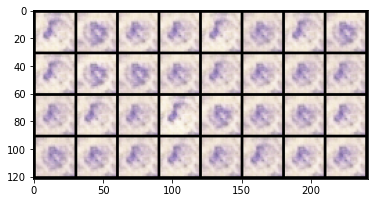

Epoch: [49] [   0/ 146] time: 208.6202, d_loss: 0.32278383, g_loss: 2.36534810
Epoch: [49] [   1/ 146] time: 208.6486, d_loss: 0.29193783, g_loss: 1.90318525
Epoch: [49] [   2/ 146] time: 208.6914, d_loss: 0.39817172, g_loss: 1.74367356
Epoch: [49] [   3/ 146] time: 208.7464, d_loss: 0.48440075, g_loss: 2.16858339
Epoch: [49] [   4/ 146] time: 208.8014, d_loss: 0.40411919, g_loss: 2.32491589
Epoch: [49] [   5/ 146] time: 208.8580, d_loss: 0.23109001, g_loss: 2.31680536
Epoch: [49] [   6/ 146] time: 208.9114, d_loss: 0.20012882, g_loss: 2.56692505
Epoch: [49] [   7/ 146] time: 208.9649, d_loss: 0.38356751, g_loss: 2.06962585
Epoch: [49] [   8/ 146] time: 209.0191, d_loss: 0.45075169, g_loss: 2.49053764
Epoch: [49] [   9/ 146] time: 209.0756, d_loss: 0.28261331, g_loss: 1.87076354
Epoch: [49] [  10/ 146] time: 209.1295, d_loss: 0.36894447, g_loss: 2.26518321
Epoch: [49] [  11/ 146] time: 209.1839, d_loss: 0.30259287, g_loss: 3.21827626
Epoch: [49] [  12/ 146] time: 209.2392, d_loss: 0.26

Epoch: [49] [ 105/ 146] time: 214.3301, d_loss: 0.47872269, g_loss: 1.54293561
Epoch: [49] [ 106/ 146] time: 214.3867, d_loss: 0.47644597, g_loss: 2.48642373
Epoch: [49] [ 107/ 146] time: 214.4406, d_loss: 0.62399811, g_loss: 1.41915917
Epoch: [49] [ 108/ 146] time: 214.4950, d_loss: 0.50010508, g_loss: 1.33408642
Epoch: [49] [ 109/ 146] time: 214.5495, d_loss: 0.66896391, g_loss: 1.95295405
Epoch: [49] [ 110/ 146] time: 214.6057, d_loss: 0.49119198, g_loss: 1.70814741
Epoch: [49] [ 111/ 146] time: 214.6590, d_loss: 0.35688642, g_loss: 1.79775095
Epoch: [49] [ 112/ 146] time: 214.7131, d_loss: 0.40176883, g_loss: 1.80852246
Epoch: [49] [ 113/ 146] time: 214.7673, d_loss: 0.37694889, g_loss: 2.27165413
Epoch: [49] [ 114/ 146] time: 214.8222, d_loss: 0.46947688, g_loss: 1.99130034
Epoch: [49] [ 115/ 146] time: 214.8790, d_loss: 0.29597610, g_loss: 2.60492873
Epoch: [49] [ 116/ 146] time: 214.9329, d_loss: 0.42184430, g_loss: 2.25824189
Epoch: [49] [ 117/ 146] time: 214.9874, d_loss: 0.39

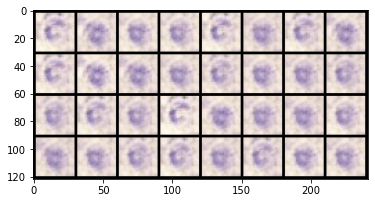

In [15]:
import time

opt.max_epoch=50
discriminator_err_real_history = []
discriminator_err_fake_history = []
start_time = time.time()
generator_error_history = []
for epoch in range(opt.max_epoch):
    for ii,data in enumerate(train_loader):
        real,_ = data
        label_real = torch.ones(real.size(0))
        label_fake = torch.zeros(real.size(0))
        noise = torch.randn(real.size(0),opt.nz,1,1)

        if opt.gpu:
            noise=noise.cuda()
            real=real.cuda()
            label_real=label_real.cuda()
            label_fake = label_fake.cuda()
        # train discriminator
        netd.zero_grad()
        # train with real images
        out_d = netd(real)
        error_real = criterion(out_d.squeeze(),label_real)
        error_real.backward()
        D_x = out_d.mean()
        # train with fake images
        fake_imgs = netg(noise).detach()
        out_d_g_z = netd(fake_imgs)
        error_fake = criterion(out_d_g_z.squeeze(),label_fake)
        error_fake.backward()
        D_g_z = out_d_g_z.mean()
        error_d = error_real + error_fake
        optimizerD.step()
        discriminator_err_real_history.append(error_real)
        discriminator_err_fake_history.append(error_fake)

        # train generator
        netg.zero_grad()
        noise.normal_(0,1) # get fresh batch of noise
        fake_imgs = netg(noise)
        out_d_g_z2 = netd(fake_imgs)
        error_g = criterion(out_d_g_z2.squeeze(),label_real)
        error_g.backward()
        optimizerG.step()
        D_G_z2 = out_d_g_z2.mean()
        generator_error_history.append(error_g)
        print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, ii, len(train_loader), time.time() - start_time, error_fake+error_real, error_g))

# if ii % 10 == 0:
    fake_u = netg(fix_noise)
    imgs = make_grid(fake_u*0.5 + 0.5).cpu() #CHW
    plt.imshow(imgs.permute(1,2,0).numpy())
    plt.show()




In [16]:
fix_noise = torch.FloatTensor(1,opt.nz,1,1).normal_(0,1)

In [18]:
fake_u = netg(fix_noise.cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


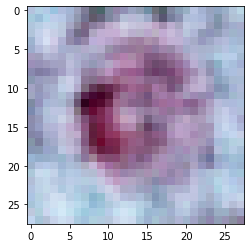

In [19]:
import cv2
g_img = fake_u[0].permute(1, 2, 0).cpu().detach().numpy()
g_img = cv2.cvtColor(g_img, cv2.COLOR_BGR2RGB)
plt.imshow(g_img)
plt.show()

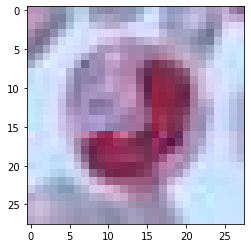

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])


In [20]:
for i, l in train_loader:
    g_img = i[0].permute(1, 2, 0).numpy()
    g_img = cv2.cvtColor(g_img, cv2.COLOR_BGR2RGB)
    plt.imshow(g_img)
    plt.show()
    print(l)
    break

In [21]:
# torch.save(netg.state_dict(), "generator")
# torch.save(netd.state_dict(), "discriminator")